2017 edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.

# Important note for grading
This notebook displays a series of questions, that we use to grade the work done. Since the following questions are rather basic, and do not change much from year to year, they only allow reaching the grade 10/20. Additional points can be gained by showing originality, depth, algorithmic design and implementations beyond that used in the notebook. Remember that this should become your own notebook: there is ample room for creativity!

# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [81]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)

Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [82]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
How many distinct users do we have in our data? 

```python
uniqueUsers = userArtistDF.select(...)...
print("Total n. of users: ", uniqueUsers)
```

In [83]:
u1 = userArtistDF.select('userID').orderBy('userID')
#u1.show()
#print(u1.count())
uniqueUsers = userArtistDF.select('userID').distinct().orderBy('userID').cache()
uniqueUsers.show()
print("Total n. of users: ", uniqueUsers.count())

+------+
|userID|
+------+
|    90|
|    98|
|   116|
|   120|
|   128|
|   139|
|   277|
|   321|
|   340|
|   350|
|   384|
|   519|
|   521|
|   536|
|   581|
|   619|
|   629|
|   659|
|   691|
|   713|
+------+
only showing top 20 rows

Total n. of users:  148111


#### Question 1.2
How many distinct artists do we have in our data ?

```python
uniqueArtists = userArtistDF.select(...)...
print("Total n. of artists: ", uniqueArtists)
```

In [84]:
uniqueArtists = userArtistDF.select('artistID').distinct().orderBy('artistID').cache()
uniqueArtists.show()
print("Total n. of artists: ", uniqueArtists.count())

+--------+
|artistID|
+--------+
|       1|
|       2|
|       3|
|       4|
|       5|
|       6|
|       7|
|       8|
|       9|
|      11|
|      13|
|      14|
|      15|
|      16|
|      17|
|      18|
|      19|
|      21|
|      22|
|      23|
+--------+
only showing top 20 rows

Total n. of artists:  1631028


#### Question 1.3

One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than Integer.MAX_VALUE, or 2147483647, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.

What are the maximum and minimum values of column `userID` ?

HINT: Refer to section 4.3 of Laboratory 2.

```python
userArtistDF....show()
```

In [85]:
#print(uniqueUsers.rdd.max()[0])
userArtistDF.select(max('userID')).show()
#userArtistDF.agg({"userID": "max"}).collect()

#print(uniqueUsers.rdd.min()[0])
userArtistDF.select(min('userID')).show()
#userArtistDF.agg({"userID": "min"}).collect()

+-----------+
|max(userID)|
+-----------+
|    2443548|
+-----------+

+-----------+
|min(userID)|
+-----------+
|         90|
+-----------+



#### Question 1.4
What is the maximum and minimum values of column `artistID` ?

```python
userArtistDF...
```

In [86]:
#print(uniqueArtists.rdd.max()[0])
userArtistDF.select(max('artistID')).show()
#userArtistDF.agg({"artistID": "max"}).collect()

#print(uniqueArtists.rdd.min()[0])
userArtistDF.select(min('artistID')).show()
#userArtistDF.agg({"artistID": "min"}).collect()

+-------------+
|max(artistID)|
+-------------+
|     10794401|
+-------------+

+-------------+
|min(artistID)|
+-------------+
|            1|
+-------------+



We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
How many times each user has played a song? Show 5 samples of the result.

```python
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy(...).sum(...).collect()
print(userActivity[0:5])
```

In [87]:
#check the min and max value of playcounts

userArtistDF.select(max('playCount')).show()
userArtistDF.select(min('playCount')).show()

userActivity = userArtistDF.groupBy('userID').sum('playCount')
userActivity.show(5)
print("The top 10 users based on playcounts is: ")
top10_userActivity=userActivity.orderBy('sum(playCount)', ascending=0).limit(10)
top10_userActivity.show()

+--------------+
|max(playCount)|
+--------------+
|        439771|
+--------------+

+--------------+
|min(playCount)|
+--------------+
|             1|
+--------------+

+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1000061|           244|
|1000070|         20200|
|1000313|           201|
|1000832|          1064|
|1000905|           214|
+-------+--------------+
only showing top 5 rows

The top 10 users based on playcounts is: 
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1059637|        674412|
|2064012|        548427|
|2069337|        393515|
|2023977|        285978|
|1046559|        183972|
|1052461|        175822|
|1070932|        168977|
|1031009|        167273|
|2020513|        165642|
|2062243|        151504|
+-------+--------------+



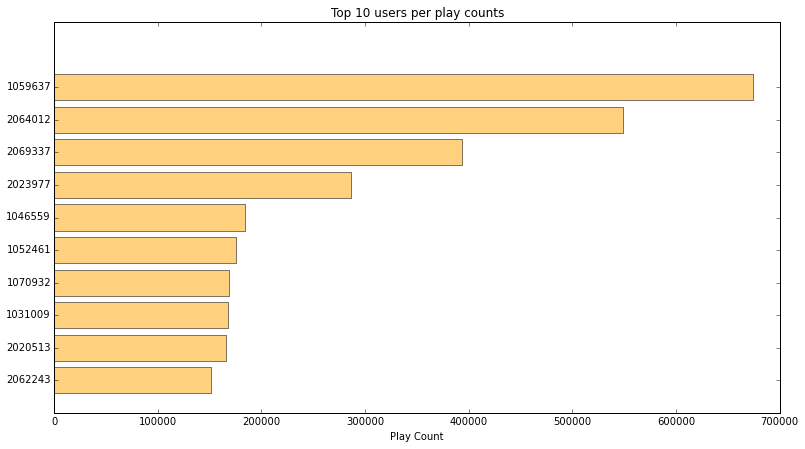

In [88]:
top10_userActivity_PD = pd.DataFrame(data=top10_userActivity.collect())

y_pos = np.arange(len(top10_userActivity_PD[0].values))
plt.figure(figsize=(13,7))

plt.barh(y_pos, top10_userActivity_PD[1].values, align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, top10_userActivity_PD[0].values)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.title('Top 10 users per play counts')
plt.show()

#### Question 2.2
Plot CDF (or ECDF) of the number of play counts per User ID.

Explain and comment the figure you just created: 

* for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible.
* discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system.
* look at outliers and reason about their impact on your reccommender algorithm

```python
pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

plt....( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()
```

Percentiles:
0.00         1
0.10        34
0.20       132
0.25       204
0.30       293
0.40       535
0.50       892
0.60      1415
0.70      2226
0.75      2800
0.80      3584
0.90      6484
1.00    674412
Name: 1, dtype: float64


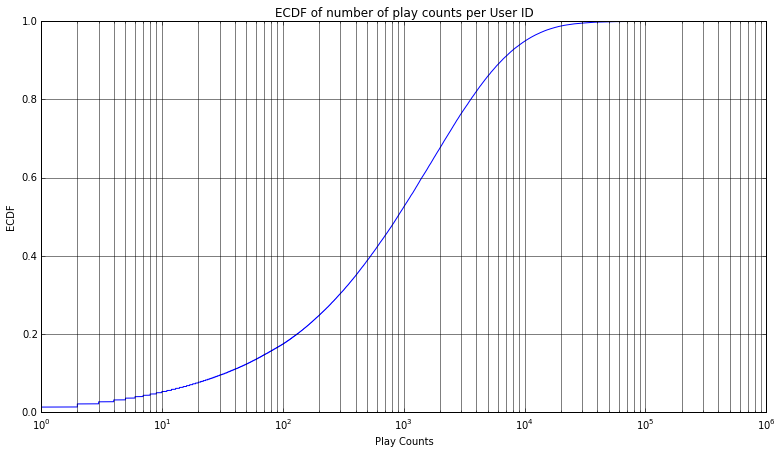

In [89]:
pdf = pd.DataFrame(data=userActivity.collect())
Y=np.sort(pdf[1])
yvals=np.arange(len(Y))/float(len(Y))
print('Percentiles:')
print(pdf.quantile([.0,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,1.0])[1])

plt.figure(figsize=(13,7))
plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

Here we use a semilog plot because otherwise the plot is impossible to read (range of playcounts too wide)

Some users have a very low playcount, this says that for this user, it will be more difficult to make accurate predictions, since we have not enough data. On the other hand, there are some users with a very high playcount. We think that for that type of users it will be easier to make some recommendations, unless they listened always the same artist, which is not very plausible.

I take the log of the number of counts in order to be able to undersrand the data and look at the percentiles.

25% percentile: ~ 200 playcounts 

50% percentile: ~ 800 playcounts 

75% percentile: ~ 2800 playcounts 

90% percentile: ~ 6500 playcounts 

Between 100 and 3000 playcounts we have about 50% of the users, they are still a lot of users, which exclude without any doubt outliers (too high, too low playcounts).

We don't know how the data distribution can influence the recommender system, we need to check. Maybe it's better to leave out users with low playcounts?

#### Question 2.3

How many play counts for each artist? Plot CDF or ECDF of the result.

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?

```python
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF. ...
```

```python
pdf = pd.DataFrame(data=artistPopularity)
...
...
...
```

Percentiles:
0.00          1
0.10          1
0.20          1
0.25          1
0.30          1
0.40          2
0.50          3
0.60          5
0.70          8
0.75         11
0.80         15
0.90         45
0.95        126
0.99       1402
1.00    2502130
Name: 1, dtype: float64


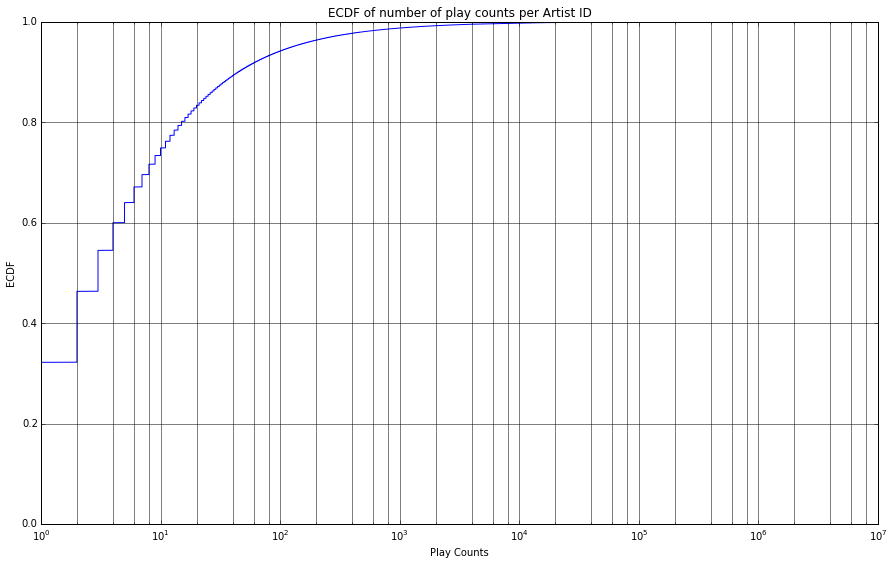

In [90]:
artistPopularity = userArtistDF.groupBy('artistID').sum('playCount').cache().collect()
#userArtistDF.groupBy('artistID').sum('playCount').limit(5).show()

pdf = pd.DataFrame(data=artistPopularity)
Y=np.sort(pdf[1])
yvals=np.arange(len(Y))/float(len(Y))
print('Percentiles:')
print(pdf.quantile([.0,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.95,.99,1.0])[1])

plt.figure(figsize=(15,9))
plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()

It looks that 75% of artists have less than 10 playcounts and 90% have less than 45 playcounts. This is really bad because it means that many artists are never listened. Actually about 35% of the artists have one playcount. Probably it's because there is something wrong with our data (Artist mispelled). In the following questions we'll cover that.

Even considering the 90% percentile we have artists with at most 45 playcounts, this is still very low compared to the highest playcount value,  which is 2502130.
Only 10% of the artists have more that 45 playcounts, and only 1% have more than 1%. This means that our system will probably recommend this 1% of the artists.
Maybe if we do this way we achieve an high score, but we would exclude 99% of the artists from our recommendation, and this would limit the fairness of our system.


#### Question 2.4
Plot a bar chart to show top 5 artists In terms of absolute play counts.

Comment the figure you just obtained:

* are these reasonable results?
* is looking at top-5 artists enough to learn more about your data?
* do you see anything strange in the data?

```python
sortedArtist = sorted(artistPopularity, key = lambda x: -x[...])[: ...]

artistID = [w[...] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()
```

In [91]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t',mode='DROPMALFORMED') \
    .load(base + "artist_data.txt",schema = customSchemaArtist) \
    .cache()

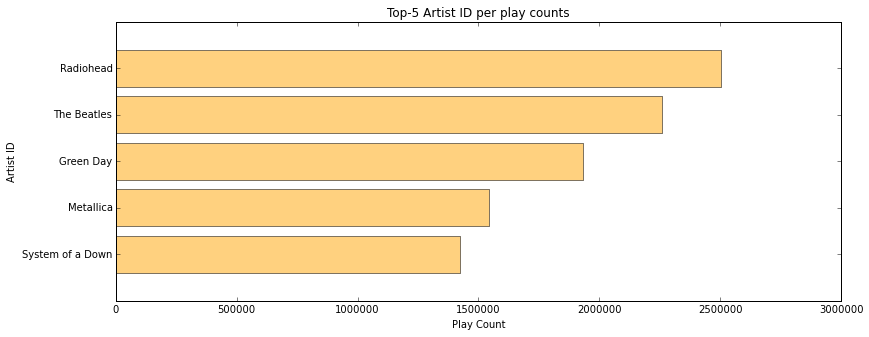

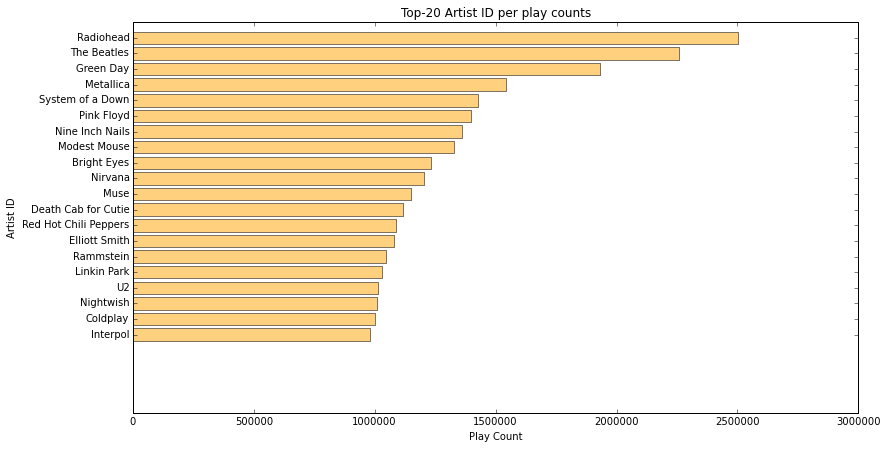

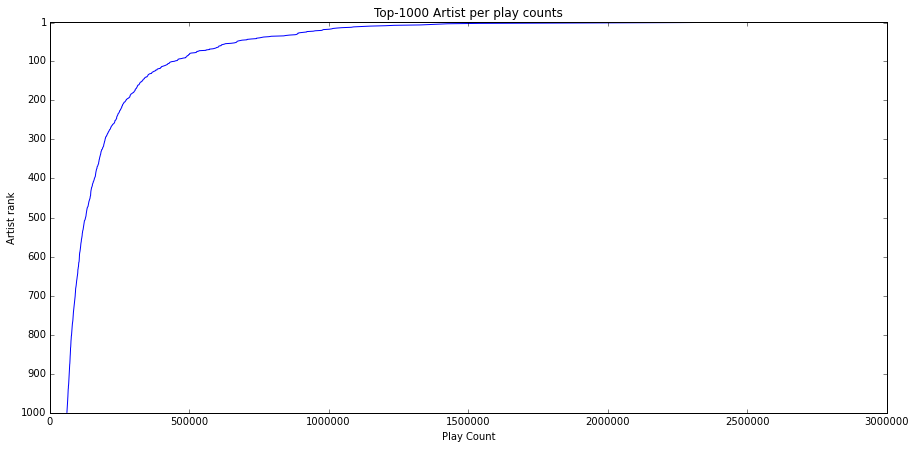

Artist in position 1 has 2502130 playcounts
Artist in position 1000 has 61309 playcounts


In [92]:
artistPopularity = (
    userArtistDF
    .groupBy('artistID').sum('playCount')
    .join(artistDF, userArtistDF.artistID == artistDF.artistID, "left_outer")
    .drop(userArtistDF.artistID)
    .drop(artistDF.artistID)
    .cache()
    .rdd
    .map(lambda x : (x[1] , x[0]))
    .toDF(['name','playcount'])
    .collect()
)


sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]
artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.figure(figsize=(13,5))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist ID')
plt.title('Top-5 Artist ID per play counts')
plt.show()

sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:20]
artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.figure(figsize=(13,7))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist ID')
plt.title('Top-20 Artist ID per play counts')
plt.show()

sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:1000]
artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

y_label = [1]
y_label.extend(range(100,1001,100))

plt.figure(figsize=(15,7))
plt.plot(frequency[::-1],y_pos[::-1])
plt.gca().invert_yaxis()
plt.yticks(y_label)
plt.xlabel('Play Count')
plt.ylabel('Artist rank')
plt.title('Top-1000 Artist per play counts')
plt.show()

print('Artist in position 1 has %d playcounts' % frequency[0])
print('Artist in position 1000 has %d playcounts' % frequency[-1])

As we can see, the top 5 artists have more than 1.5 million play counts.
If we look at the top 20, we can see that they all have more than 1 million of play counts.

When we look at the first 1000 artists we already see the big interval of values for what concerns the playcount.

These values seem reasonable, but we are talking about the 99% percentile (artists with more than 1400 play counts)
This conferms how much artists are different regarding play counts.
Another thing that we see is that the top 3 is actually quite different from the top 20 and the top 100, we can see it clearly looking at the first two plots (top 20 and top 5).
Anyway,it looks that after the first 3 artists, the distribution of play counts is more linear.

We still need to consider that our data is biased: artists-ids are still dirty (more artist id for each artist).

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.

HINT: If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

```python
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    ...
    ...
    ...
    
artistDF.show(5)
```

We do not load /datasets/lastfm/artist_data.txt because we already loaded it before

In [93]:
artistDF.cache()

artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
Find 20 artists whose name contains "Aerosmith". Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?

HINT: Function `locate(sub_string, string)` can be useful in this case.

```python
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", ...) > 0].show(...)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()
```

In [94]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", 'name') > 0].show(20)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

They are clearly the same artist. The problem is that in same cases we have many featurings, and an optimal approach would be to add a playcount to all the artist mentioned and then eliminate the featuring artistID. This is too difficult to do, so we decided to leave it there

In [95]:
print("Here another example to show that the featuring problem is  present in all the data :")

artistDF[locate("50 Cent", 'name') > 0].show(20)

Here another example to show that the featuring problem is  present in all the data :
+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10584756|P. Diddy ft. Noto...|
|10435135|Lloyd Banks Feat....|
| 1240504| 50 Cent ft. Emninem|
|10435218|  Missy Feat 50 Cent|
| 7031312|50 Cent/Biggie Sm...|
|10024883|Eminem Dr.Dre 50 ...|
| 1136301|50 Cent and Madd ...|
| 1136311|50 Cent and Missy...|
| 1136317|50 Cent and Nate ...|
| 1136665|      Eminem 50 Cent|
| 1244879|50 Cent & Eminem ...|
|10026240|   D12 (ft. 50 Cent)|
|10435394|50 Cent Feat. Llo...|
| 1245591|50 Cent, Eminem, ...|
|10026808| 50 Cent (on hot 97)|
|10027151|50 Cent f/ Lloyd ...|
| 1138015|50 Cent, Destiiny...|
|10027268|Nas F/ 50 Cents, ...|
| 1246695|Talib Kweli, Mos ...|
| 1247022|Eminem/50 Cent/Bu...|
+--------+--------------------+
only showing top 20 rows



To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.

```python
customSchemaArtistAlias = StructType([ \
    StructField( ... ), \
    StructField( ... )])

artistAliasDF = sqlContext.read \
    ...
    ...
    ...

artistAliasDF.show(5)
```

In [96]:
customSchemaArtistAlias = StructType([ \
    StructField( "mispelledID", LongType(), True ), \
    StructField( "standard", LongType(), True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t',mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt",schema = customSchemaArtistAlias) \
    .cache()
artistAliasDF.show(5)

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    1092764| 1000311|
|    1095122| 1000557|
|    6708070| 1007267|
|   10088054| 1042317|
|    1195917| 1042317|
+-----------+--------+
only showing top 5 rows



#### Question 3.4
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.

```python
artistAliasDF[ ... ].show()
artistAliasDF[ ... ].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset
```

In [97]:
artistAliasDF[artistAliasDF.mispelledID==1000010].show()
artistAliasDF[artistAliasDF.mispelledID==2082323].show()

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
+-----------+--------+

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    2082323| 1000010|
+-----------+--------+



As we can see, the two artists are the same but '01 Aerosmith' is a mispelled name of 'Aerosmith'.
In the first table there is nothing because 1000010 is the 'official' ArtistID or the artist.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.

HINT: Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.

```python
artistAlias = artistAliasDF.rdd.map(lambda row: ( ... , ...)). ...
```

In [98]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0] , row[1])).collectAsMap()

#### Question 4.2
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.

**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

```python
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map( ... ), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))
```

In [99]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()
#map artist_alias with artist 
newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs ), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()
print('The mapping phase takes %f seconds' %(t1-t0))
newUserArtistDF.cache()
t0 = time()
print('before we had ' + str(userArtistDF.select('artistID').distinct().cache().count()) + ' artists')
newUniqueArtistsDF = newUserArtistDF.select('artistID').distinct().cache()
print('after the cleaning we have ' + str(newUniqueArtistsDF.count()) + ' artists')
t1 = time()
print('The distinct phase takes %f seconds' %(t1-t0))
artistAliasDF_mispelled = artistAliasDF.select('mispelledID')


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The mapping phase takes 1.059718 seconds
before we had 1631028 artists
after the cleaning we have 1568126 artists
The distinct phase takes 46.668435 seconds


As we can see, before the cleaning we had 1631028 artist, while after a first cleaning we have 1568126 artists. In addition, we have seen that the cleaning takes few time, while it takes a lot to do the distinct of the two tables.
We also need to be careful because we mapped every artistID to the standard one, but now we have more entries per (userID,artistID)

In [100]:
Artist_intersectionDF = (
    sqlContext
    .createDataFrame(newUniqueArtistsDF.rdd.intersection(artistAliasDF_mispelled.rdd) ,['Artist Intersection ID'])
    .cache()
)

print('artist aliases after first clean are: ' + str(Artist_intersectionDF.count()))
Artist_intersectionDF.show()

artist aliases after first clean are: 20
+----------------------+
|Artist Intersection ID|
+----------------------+
|               1206735|
|               1001864|
|               6603878|
|                   754|
|               1008798|
|               6817660|
|               1006322|
|               1167860|
|               1042639|
|               1014100|
|              10151717|
|               1014175|
|               1013851|
|               1235697|
|               1014609|
|               1018110|
|               1245218|
|               1006347|
|               1136715|
|                    15|
+----------------------+



This looks ok, but we still have some aliases. We discovered this by doing an intersection of the artist column with the 'forbidden' alias column, and the result is not empty, this means that we need to clean our data again.

The reason why alias artistIDs remain is that in the first run the mispelled artists are replaced with an id, which might still be invalid. 
This is because in the alias artist table we have a sort of chained pointer derefence. That means that we need many runs until we completely clean our data. 
We can do this by applying the same concept until the intersection is empty.
In the following code we show an example of such chain of artist aliases

In [101]:
print('As we can see, first ID found before in the intersection (1206735), is the standard ID associated to an alias (10215049)')
artistAliasDF[artistAliasDF.standard==1206735].show()
print('Since the standard ID (1206735) appears in the intersection, it means that this is still an alias of another standard ID (1240689)')
artistAliasDF[artistAliasDF.mispelledID==1206735].show()

print('As we can see, the last standard ID found, is a real standard ID, this is because it is not an alias of anything')
artistAliasDF[artistAliasDF.mispelledID==1240689].show()

print('Now, let\'s look at the names that match those artist ID')
artistDF[artistDF.artistID==10215049].show()
artistDF[artistDF.artistID==1206735].show()
artistDF[artistDF.artistID==1240689].show()



standard_alias_intersectionDF = (
    sqlContext
    .createDataFrame(artistAliasDF.select('standard').rdd.intersection(artistAliasDF_mispelled.rdd) ,['Artist Intersection ID'])
    .cache()
)

print('In order to see if this is a recurrent problem, we did the intersection between the alias column and the standard column, and we have found ' + str(standard_alias_intersectionDF.count()) + ' conflicts')

standard_alias_intersectionDF.show()

As we can see, first ID found before in the intersection (1206735), is the standard ID associated to an alias (10215049)
+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|   10215049| 1206735|
+-----------+--------+

Since the standard ID (1206735) appears in the intersection, it means that this is still an alias of another standard ID (1240689)
+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    1206735| 1240689|
+-----------+--------+

As we can see, the last standard ID found, is a real standard ID, this is because it is not an alias of anything
+-----------+--------+
|mispelledID|standard|
+-----------+--------+
+-----------+--------+

Now, let's look at the names that match those artist ID
+--------+------------+
|artistID|        name|
+--------+------------+
|10215049|Chodios Bros|
+--------+------------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 1206735|chiodos bros|
+--------+------------+

+--------+--

In [102]:
#map artist_alias with artist 
newUserArtistDF_2 = sqlContext.createDataFrame(
    newUserArtistDF.rdd.map(replaceMispelledIDs ), 
    userArtistDataSchema
).cache()

print('before we had ' + str(newUserArtistDF.select('artistID').distinct().cache().count()) + ' artists')
newUniqueArtistsDF = newUserArtistDF_2.select('artistID').distinct().cache()
print('after the cleaning we have ' + str(newUniqueArtistsDF.count()) + ' artists')

Artist_intersectionDF = (
    sqlContext
    .createDataFrame(newUniqueArtistsDF.rdd.intersection(artistAliasDF_mispelled.rdd) ,['Artist Intersection ID'])
    .cache()
)

print('artist aliases after second clean are: ' + str(Artist_intersectionDF.count()))
Artist_intersectionDF.show()

before we had 1568126 artists
after the cleaning we have 1568117 artists
artist aliases after second clean are: 11
+----------------------+
|Artist Intersection ID|
+----------------------+
|               1001864|
|                   754|
|               1008798|
|               1006322|
|               1167860|
|               1014175|
|               1013851|
|               1014609|
|               1018110|
|               1006347|
|                    15|
+----------------------+



In [103]:
#map artist_alias with artist 
newUserArtistDF_3 = sqlContext.createDataFrame(
    newUserArtistDF_2.rdd.map(replaceMispelledIDs ), 
    userArtistDataSchema
).cache()

print('before we had ' + str(newUserArtistDF_2.select('artistID').distinct().cache().count()) + ' artists')
newUniqueArtistsDF = newUserArtistDF_3.select('artistID').distinct().cache()
print('after the cleaning we have ' + str(newUniqueArtistsDF.count()) + ' artists')

Artist_intersectionDF = (
    sqlContext
    .createDataFrame(newUniqueArtistsDF.rdd.intersection(artistAliasDF_mispelled.rdd) ,['Artist Intersection ID'])
    .cache()
)

print('artist aliases after third clean are: ' + str(Artist_intersectionDF.count()))
Artist_intersectionDF.show()

before we had 1568117 artists
after the cleaning we have 1568117 artists
artist aliases after third clean are: 11
+----------------------+
|Artist Intersection ID|
+----------------------+
|               1001864|
|                   754|
|               1008798|
|               1006322|
|               1167860|
|               1014175|
|               1013851|
|               1014609|
|               1018110|
|               1006347|
|                    15|
+----------------------+



As we can see, two cleaning steps are enough because the result after the third cleaning doesn't change. If more cleaning phases were required, we could loop untile the result does not change.

In [104]:
artistAliasDF[artistAliasDF.mispelledID==15].show()
equalIDDF = artistAliasDF[artistAliasDF.mispelledID==artistAliasDF.standard].cache()
(
equalIDDF
.join(artistDF, equalIDDF.mispelledID == artistDF.artistID, "left_outer")
.drop('artistID')
.show()
)

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|         15|      15|
+-----------+--------+

+-----------+--------+---------------+
|mispelledID|standard|           name|
+-----------+--------+---------------+
|    1008798| 1008798|          µ-Ziq|
|    1013851| 1013851|       Värttinä|
|    1167860| 1167860|    Herman Düne|
|        754|     754|      Sigur Rós|
|    1006322| 1006322|            múm|
|    1006347| 1006347|          Dälek|
|         15|      15|          Björk|
|    1014609| 1014609|    Mötley Crüe|
|    1018110| 1018110|Lars Winnerbäck|
|    1014175| 1014175|  Señor Coconut|
|    1001864| 1001864|       Röyksopp|
+-----------+--------+---------------+



Here we can see that there are some artists that have the same misplelled and standard ID. Since they look legit names, we keep them. We have also noted that these artists are accomunated from the fact that in their name there are accented letters.

In [105]:
print('Before cleaning:')
userArtistDF.orderBy('playCount', ascending=False).cache().show(5)

print('After cleaning:')

userArtist_cleanDF = (
    newUserArtistDF_3
    .groupBy(['userID','artistID'])
    .sum('playCount')
    .withColumnRenamed("sum(playCount)", "playCount")
    .orderBy('playCount', ascending=False)
    .cache()

)
userArtist_cleanDF.show(5)


Before cleaning:
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2064012|    4468|   439771|
|1059637| 1002095|   433060|
|1059637| 1026440|   155895|
|2069889| 1002095|   101076|
|2020513| 1007801|    88908|
+-------+--------+---------+
only showing top 5 rows

After cleaning:
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2064012|    4468|   439771|
|1059637| 1002095|   433060|
|1059637| 1026440|   155895|
|2069889| 1002095|   101076|
|2020513| 1007801|    89592|
+-------+--------+---------+
only showing top 5 rows



As we can see, simply looking at the top 5 user, there is a difference in the playcount of the fifth user. Thus we can say that the cleaning has an effect on the playcounts, even if it's not that big.

#### Question 4.3
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task. 

We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. 

The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`

To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.


```python
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(... , ...)
    return (... , ..., ...)

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()
```

In [106]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs ),#if row.artistID in artistAliasDF[0].collect()[0].'misppelledID' ), 
    userArtistDataSchema
)

t1 = time()
print('The script takes %f seconds' %(t1-t0))

The script takes 0.020072 seconds


As we can see, explicitly creating broadcast variables save us some time (1 second)

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1

How many unique artists? Compare with the result when using old data.

```python
uniqueArtists = newUserArtistDF. ...

print("Total n. of artists: ", uniqueArtists)
```

In [107]:
newUniqueArtistsDF = userArtist_cleanDF.select('artistID').distinct().cache()
print("Total n. of artists before cleaning: "+str(uniqueArtists.count()))
print("Total n. of artists after cleaning: "+str(newUniqueArtistsDF.count()))
print("Total n. of artists cleaned: "+str( uniqueArtists.count() - newUniqueArtistsDF.count()))
difference = (uniqueArtists.count() - newUniqueArtistsDF.count())/uniqueArtists.count()
print(str( '{0:.2f}'.format(difference*100 )) + '% were misspelled')

Total n. of artists before cleaning: 1631028
Total n. of artists after cleaning: 1568117
Total n. of artists cleaned: 62911
3.86% were misspelled


#### Question 5.2

Who are the top-10 artistis?
  * In terms of absolute play counts
  * In terms of "audience size", that is, how many users listened to one of their track at least once
  
Plot the results, and explain the figures you obtain.

```python
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy( ... ).sum( ... ).orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()
```

Before cleaning:
+--------+----------------+--------------+
|artistID|            name|sum(playCount)|
+--------+----------------+--------------+
|     979|       Radiohead|       2502130|
| 1000113|     The Beatles|       2259185|
|    4267|       Green Day|       1930592|
| 1000024|       Metallica|       1542806|
|    4468|System of a Down|       1425942|
|      82|      Pink Floyd|       1399418|
|     831| Nine Inch Nails|       1361392|
| 1001779|    Modest Mouse|       1328869|
| 1000130|     Bright Eyes|       1234387|
|     976|         Nirvana|       1203226|
+--------+----------------+--------------+
only showing top 10 rows

After cleaning:
+--------+----------------+--------------+
|artistID|            name|sum(playCount)|
+--------+----------------+--------------+
|     979|       Radiohead|       2502596|
| 1000113|     The Beatles|       2259825|
|    4267|       Green Day|       1931143|
| 1000024|       Metallica|       1543430|
|    4468|System of a Down|       1426

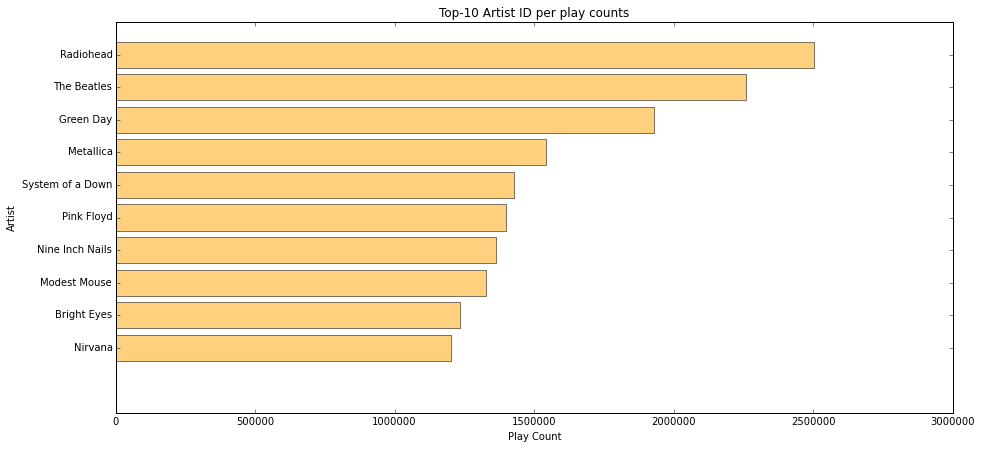

In [108]:
# calculate top-10 artists in term of play counts
print('Before cleaning:')
ArtistPC_dirty = ( 
    userArtistDF
    .groupBy('artistID')
    .sum('playCount')
    .join(artistDF, userArtistDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .orderBy('sum(playCount)', ascending=0)
    .select('artistID','name','sum(playCount)')
    .cache()
)
ArtistPC_dirty.show(10)

print('After cleaning:')
ArtistsPC_clean = ( 
    userArtist_cleanDF
    .groupBy('artistID')
    .sum('playCount')
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .orderBy('sum(playCount)', ascending=0)
    .select('artistID','name','sum(playCount)')
    .cache()
)
ArtistsPC_clean.show(10)

top10ArtistsPC = ArtistsPC_clean.take(10)

#plot

y_pos = range(len(top10ArtistsPC))
x_val = [w[2] for w in top10ArtistsPC]
y_val = [w[1] for w in top10ArtistsPC]

plt.figure(figsize=(15,7))
plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()



We have noted that the cleaning has not a significant impact on the ranking, in fact the top 10 is the same before and after the cleaning. In any case, the playcounts values are affected in a limited way. 


Before cleaning:
+--------+--------------------+-------------+
|artistID|                name|audience_size|
+--------+--------------------+-------------+
|     979|           Radiohead|        45628|
|    4267|           Green Day|        43879|
| 1000113|         The Beatles|        40899|
|    1177|            Coldplay|        38489|
|     976|             Nirvana|        36823|
|    1274|Red Hot Chili Pep...|        36033|
|    1205|                  U2|        34841|
| 1000024|           Metallica|        32327|
|    3327|              Weezer|        31950|
| 1231740|     Franz Ferdinand|        30687|
+--------+--------------------+-------------+
only showing top 10 rows

After cleaning:
+--------+--------------------+-------------+
|artistID|                name|audience_size|
+--------+--------------------+-------------+
|     979|           Radiohead|        45630|
|    4267|           Green Day|        43883|
| 1000113|         The Beatles|        40919|
|    1177|           

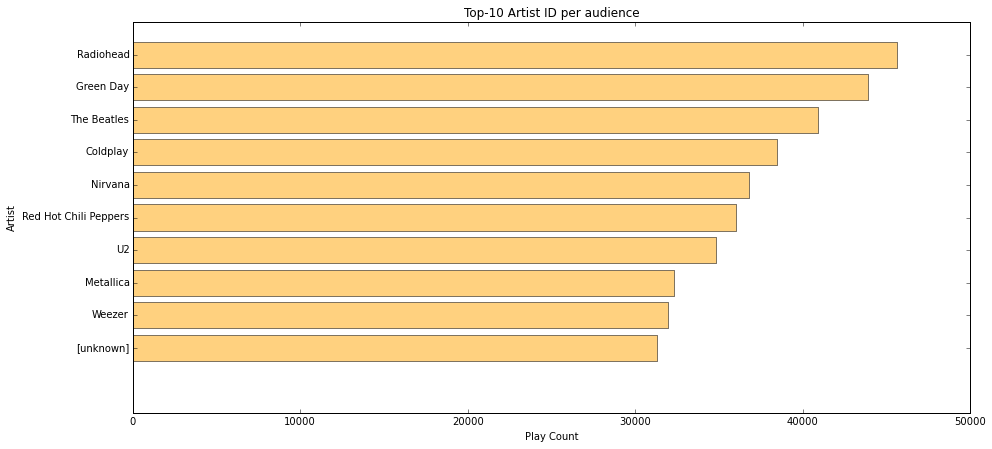

In [109]:
# calculate top-10 artists in term of "audience size"
print('Before cleaning:')
ArtistAS_dirty = ( 
    userArtistDF
    .drop('playcount')
    .groupBy('artistID')
    .count()
    .join(artistDF, userArtistDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .orderBy('count', ascending=0)
    .select('artistID','name','count')
    .withColumnRenamed("count", "audience_size")
    .cache()
)
ArtistAS_dirty.show(10)



print('After cleaning:')
ArtistsAS_clean = ( 
    userArtist_cleanDF
    .drop('playcount')
    .groupBy('artistID')
    .count()
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .orderBy('count', ascending=0)
    .select('artistID','name','count')
    .withColumnRenamed("count", "audience_size")
    .cache()
)
ArtistsAS_clean.show(10)

top10ArtistsAS = ArtistsAS_clean.take(10)
#print(top10ArtistsPC)

y_pos = range(len(top10ArtistsAS))

x_val = [w[2] for w in top10ArtistsAS]
y_val = [w[1] for w in top10ArtistsAS]

plt.figure(figsize=(15,7))
plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience')
plt.show()





In this case cleaning has a significant impact on the ranking. The real artists in the top 10 are the same, but after the cleaning we have a new 'unknown' artist with an audience of 31324. We believe that this is the result of the clenaing phase, where some misspelled artists, or songs, have been remapped to this 'unknown' artist. We think that we should not consider this artist during the recommendation phase.

In [110]:
ArtistsAS_clean.show()

+--------+--------------------+-------------+
|artistID|                name|audience_size|
+--------+--------------------+-------------+
|     979|           Radiohead|        45630|
|    4267|           Green Day|        43883|
| 1000113|         The Beatles|        40919|
|    1177|            Coldplay|        38497|
|     976|             Nirvana|        36823|
|    1274|Red Hot Chili Pep...|        36036|
|    1205|                  U2|        34853|
| 1000024|           Metallica|        32337|
|    3327|              Weezer|        31951|
| 1034635|           [unknown]|        31324|
| 1231740|     Franz Ferdinand|        30692|
|      82|          Pink Floyd|        30661|
| 1270639|         The Killers|        30214|
|    1307|   The White Stripes|        29804|
|     189|            The Cure|        29161|
|     352|                Beck|        29153|
|    1394|        Led Zeppelin|        29117|
|     930|              Eminem|        28974|
| 1275996|              R.E.M.|   

Percentiles:
0.00        1
0.10        1
0.20        1
0.25        1
0.30        1
0.40        1
0.50        1
0.60        1
0.70        2
0.75        2
0.80        3
0.90        8
0.95       19
0.99      158
1.00    45630
Name: 1, dtype: float64


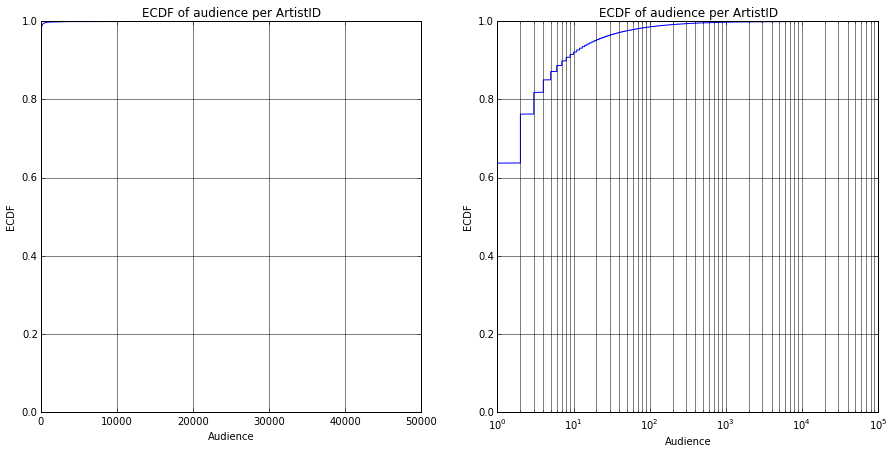

In [111]:
artistAudience = ArtistsAS_clean.drop('name').collect()

pdf = pd.DataFrame(data=artistAudience)
Y=np.sort(pdf[1])
yvals=np.arange(len(Y))/float(len(Y))
print('Percentiles:')
print(pdf.quantile([.0,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.95,.99,1.0])[1])

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot( Y, yvals )
plt.xlabel('Audience')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of audience per ArtistID')

plt.subplot(122)
plt.semilogx( Y, yvals )
plt.xlabel('Audience')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of audience per ArtistID')
plt.show()

From the graph on the left we can only state that the audience distribution is very unbalanced. From the graph on the right it's a bit more clear the general distribution. With the help of the percentiles showed in table, we can see that 60% of the artists have one user audience. On the other hand, only 1% of the artists have more than 158 fans. This result is similar to the one that we obtained plotting the ECDF of playcounts per artist, but this actually is even more meaningful. We think that this is the proof that also after the cleaning, a great part of our dataset is dirty.

In [112]:
ArtistsAS_clean.orderBy('audience_size').show(20, truncate=False)

+--------+--------------------------------------------------+-------------+
|artistID|name                                              |audience_size|
+--------+--------------------------------------------------+-------------+
|1021907 |Pqm and Dj Dome Pass mix                          |1            |
|1010983 |scarlet begonias                                  |1            |
|1020867 |Joe Zawinul The Zawinul Syndicate                 |1            |
|1006980 |Jeff Johnson Prayers of St. Brendan Shall I(Axioms|1            |
|1010843 |You Fuckin' Die                                   |1            |
|1016605 |Kekke Kulcha and Spoonhead                        |1            |
|1020320 |DIZZY GILLESPIE In South America Vol1 1956        |1            |
|2895    |Dax Raiders                                       |1            |
|1006707 |Rasa Devotion Jiv Jago (Axioms                    |1            |
|1010110 |Ragged Sharp                                      |1            |
|1010182 |Kh

Looking at the artists with the lowest audience, we note that many of them are actually songs, dirty data and mispelled artists

In [113]:
ArtistsAS_clean.filter(ArtistsAS_clean.artistID == 1093985).show()
ArtistsAS_clean.filter(ArtistsAS_clean.name == 'Labi Siffre').show()

+--------+-----------+-------------+
|artistID|       name|audience_size|
+--------+-----------+-------------+
| 1093985|Labi Saffre|            1|
+--------+-----------+-------------+

+--------+-----------+-------------+
|artistID|       name|audience_size|
+--------+-----------+-------------+
| 1008800|Labi Siffre|          456|
+--------+-----------+-------------+



Looking at a specific artist: Labi Saffre, we checked that it's actually the mispelled version of Labi Siffre, which has a much higher audience. In order to fix this we should come up with an algorithm that can match artists with similar name.

In [114]:
artist_unknownDF = artistAliasDF[artistAliasDF.standard == 1034635].cache()
print(str(artist_unknownDF.count()) + ' artists are mapped to unknown')

(
artist_unknownDF
.join(artistDF, artist_unknownDF.mispelledID == artistDF.artistID, "left_outer")
.drop('artistID')
.show(20)
)

955 artists are mapped to unknown
+-----------+--------+--------------------+
|mispelledID|standard|                name|
+-----------+--------+--------------------+
|    1271879| 1034635|                KPBS|
|    1345898| 1034635|Nieuwe artiest (199)|
|    2163801| 1034635|some japanese singer|
|    6689660| 1034635|                  ><|
|    1087215| 1034635|              RMF FM|
|    2052313| 1034635|              01  CD|
|    9906368| 1034635|    New Artist (481)|
|    6606623| 1034635|  ������������������|
|    6675539| 1034635|           Untittled|
|    1320926| 1034635|www.dancefloor.sp...|
|    1346606| 1034635|SORRY, SIREN no l...|
|    6798165| 1034635|             unknwon|
|    1309926| 1034635|     New Artist (20)|
|    6630129| 1034635|         Male singer|
|   10025808| 1034635|            asdfadsf|
|    1004048| 1034635|              Winamp|
|    1028485| 1034635|   D I G I T A L L Y|
|    1246861| 1034635|[Buffer: 88%] D I...|
|    1333381| 1034635| Nieuwe artiest (39)

As we can see, artists that are mapped to unknown are actually songs or unknown artists. Later we will remove them.

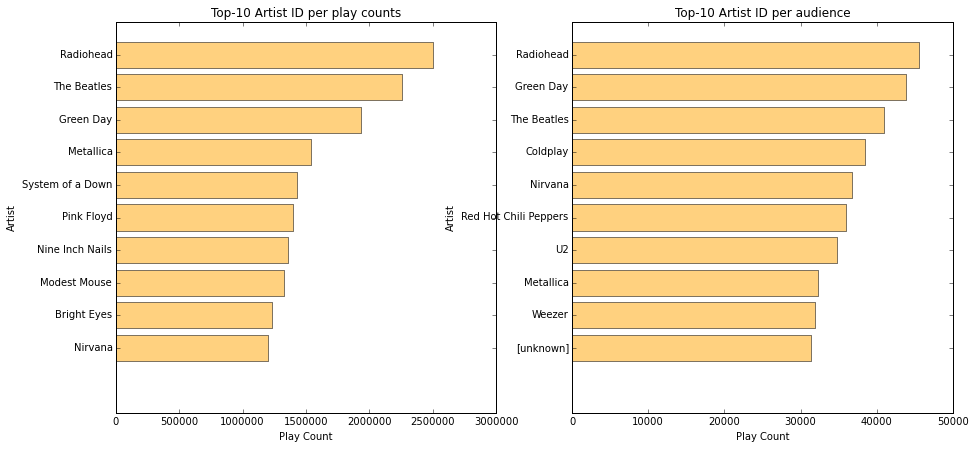

In [115]:
plt.figure(figsize=(15,7))

y_pos = range(len(top10ArtistsPC))
x_val = [w[2] for w in top10ArtistsPC]
y_val = [w[1] for w in top10ArtistsPC]
plt.subplot(121)

plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')

plt.subplot(122)
y_pos = range(len(top10ArtistsAS))
x_val = [w[2] for w in top10ArtistsAS]
y_val = [w[1] for w in top10ArtistsAS]

plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience')
plt.show()

When we compare the top 10 per playcount and per audience size, we see that being listened many times and being famous are not always correlated. 

One of the exceptions are the Radiohead, which are in the first position in both the rankings, the same is true for The Beatles and the Metallica.

There is a clear reason that explains why the unknown is present in the audience ranking and not in the playcount ranking: as seen before, many songs and unknown artists are mapped to 'unknown', this means that we are summing the audience of many different artists which are not related.

In [116]:
artist_play_aud = (
ArtistsAS_clean
.join(ArtistsPC_clean, ArtistsAS_clean.artistID == ArtistsPC_clean.artistID, "left_outer")
.drop('artistID')
.drop('name')
.collect()
)

audience = [w[0] for w in artist_play_aud]
playcount = [w[1] for w in artist_play_aud]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


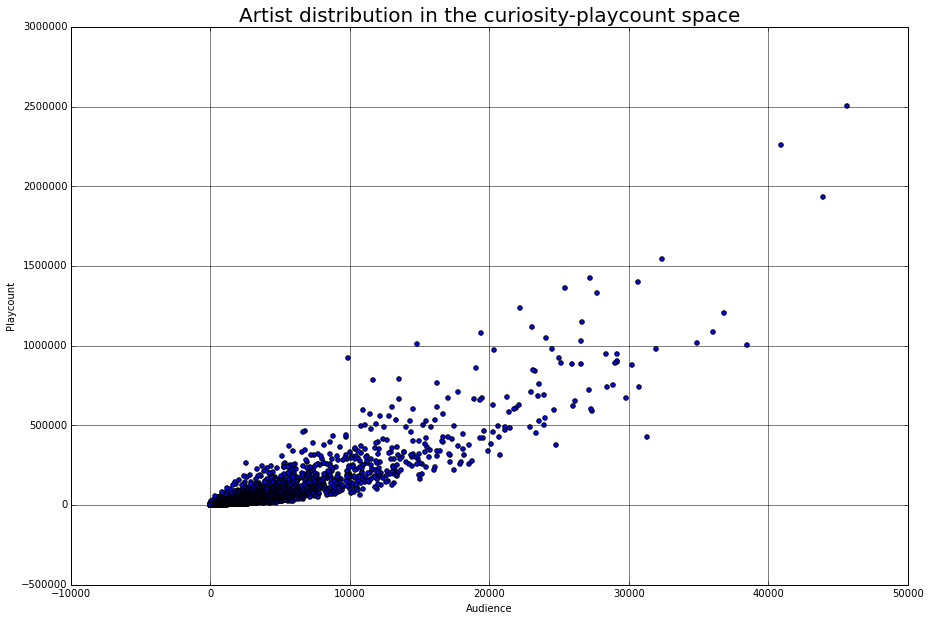

In [117]:
plt.figure(figsize=(15,10))

plt.scatter(audience, playcount)
plt.xlabel('Audience')
plt.ylabel('Playcount')
plt.grid(True,which="both",ls="-")
plt.title('Artist distribution in the curiosity-playcount space', fontsize=20)

plt.show()

From this plot we can see that artists with higher playcounts also have a larger audience. This was not completely visible comparing only the top 10 artists as we did before. This result is plausible because usually an artist with a large audience also has many playcounts.

#### Question 5.3

Who are the top-10 users?
  * In terms of absolute play counts
  * In terms of "curiosity", that is, how many different artists they listened to

Plot the results

```python
# calculate top 10 users interm of play counts
top10UsersByPlayCount = newUserArtistDF. ...

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()
```

Before cleaning:
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1059637|        674412|
|2064012|        548427|
|2069337|        393515|
|2023977|        285978|
|1046559|        183972|
|1052461|        175822|
|1070932|        168977|
|1031009|        167273|
|2020513|        165642|
|2062243|        151504|
+-------+--------------+
only showing top 10 rows

After cleaning:
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1059637|        674412|
|2064012|        548427|
|2069337|        393515|
|2023977|        285978|
|1046559|        183972|
|1052461|        175822|
|1070932|        168977|
|1031009|        167273|
|2020513|        165642|
|2062243|        151504|
+-------+--------------+
only showing top 10 rows



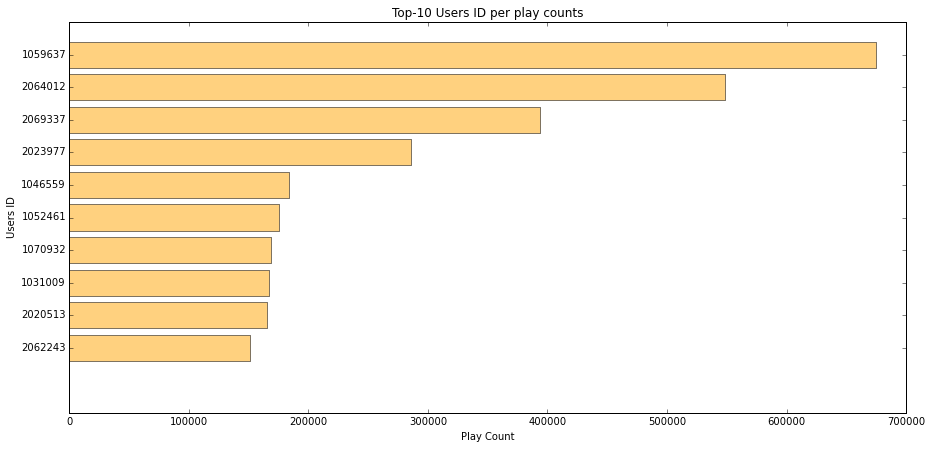

In [195]:
# calculate top-10 artists in term of play counts
print('Before cleaning:')
UsersPC_dirty = ( 
    userArtistDF
    .groupBy('userID')
    .sum('playCount')
    .orderBy('sum(playCount)', ascending=0)
    .cache()
)
UsersPC_dirty.show(10)

print('After cleaning:')
UsersPC_clean = ( 
    userArtist_cleanDF
    .groupBy('userID')
    .sum('playCount')
    .orderBy('sum(playCount)', ascending=0)
    .cache()
)
UsersPC_clean.show(10)

top10UsersPC = UsersPC_clean.take(10)
#print(top10ArtistsPC)

y_pos = range(len(top10UsersPC))
x_val = [w[1] for w in top10UsersPC]
y_val = [w[0] for w in top10UsersPC]

plt.figure(figsize=(15,7))
plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Play Count')
plt.ylabel('Users ID')
plt.title('Top-10 Users ID per play counts')
plt.show()

We can see that, except the first four users, the others have a playcount lower than 200000. This chart is not effective to explain the overall distribution of the users, we need to look at a bigger group of users.

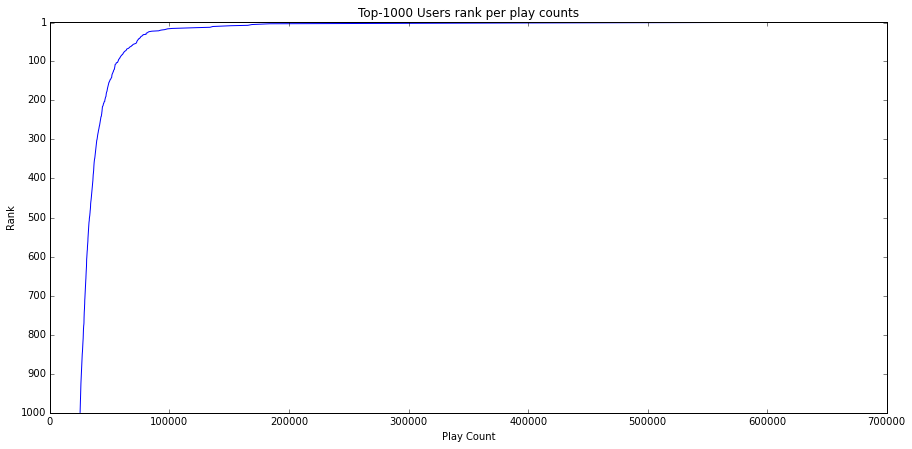

In [119]:
top1000UsersPC = UsersPC_clean.take(1000)
#print(top10ArtistsPC)


y_pos = range(len(top1000UsersPC))
x_val = [w[1] for w in top1000UsersPC]

y_label = [1]
y_label.extend(range(100,1001,100))
plt.figure(figsize=(15,7))
plt.plot(x_val[::-1],y_pos[::-1])
plt.yticks(y_label)
plt.gca().invert_yaxis()
plt.xlabel('Play Count')
plt.ylabel('Rank')
plt.title('Top-1000 Users rank per play counts')
plt.show()

In [120]:
print('Artist in position 1 has %d playcounts' % x_val[0])
print('Artist in position 1000 has %d playcounts' % x_val[-1])

Artist in position 1 has 674412 playcounts
Artist in position 1000 has 25319 playcounts


We note that except the top 50 users, which have a very high playcount, the others in the top 1000 have a range of playcounts which is around 25000

```python
# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (
                            ...
                            ...
                            ...
                         )

y_pos = range( ... )
pdf = ...

plt.barh( ... )
...
...
...
```

Before cleaning:
+-------+---------+
| userID|curiosity|
+-------+---------+
|2030067|     6836|
|1024631|     6188|
|1059334|     5864|
|2016026|     5806|
|2023686|     4863|
|1045464|     4796|
|1004584|     4709|
|2010008|     4512|
|2232770|     4115|
|1006093|     4019|
+-------+---------+
only showing top 10 rows

After cleaning:
+-------+---------+
| userID|curiosity|
+-------+---------+
|2030067|     6734|
|1024631|     6125|
|1059334|     5839|
|2016026|     5773|
|2023686|     4822|
|1045464|     4734|
|1004584|     4690|
|2010008|     4411|
|2232770|     4090|
|1006093|     4005|
+-------+---------+
only showing top 10 rows



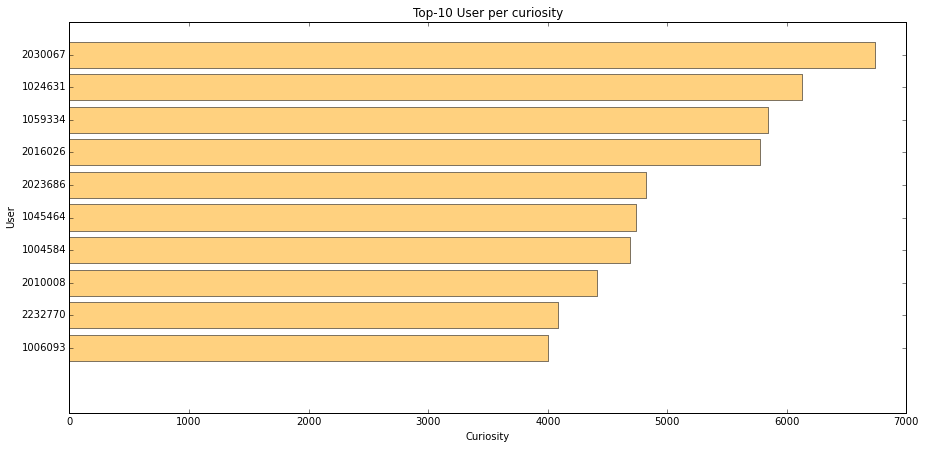

In [121]:
print('Before cleaning:')
UsersAS_dirty = ( 
    userArtistDF
    .drop('playcount')
    .groupBy('userID')
    .count()
    .orderBy('count', ascending=0)
    .withColumnRenamed("count", "curiosity")
    .cache()
)
UsersAS_dirty.show(10)



print('After cleaning:')
UsersAS_clean = ( 
    userArtist_cleanDF
    .drop('playcount')
    .groupBy('userID')
    .count()
    .orderBy('count', ascending=0)
    .withColumnRenamed("count", "curiosity")
    .cache()
)
UsersAS_clean.show(10)

top10UsersAS = UsersAS_clean.take(10)
#print(top10ArtistsPC)

y_pos = range(len(top10UsersAS))

x_val = [w[1] for w in top10UsersAS]
y_val = [w[0] for w in top10UsersAS]

plt.figure(figsize=(15,7))
plt.barh(y_pos, x_val[::-1], align='center', alpha=0.5, color='orange')
plt.yticks(y_pos, y_val[::-1])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 User per curiosity')
plt.show()

As expected, after the cleaning the curiosity value decreases for every user. This is obvious because before the cleaning the same artist had many artistIDs. 

Percentiles:
0.00       1
0.10       9
0.20      25
0.25      34
0.30      45
0.40      68
0.50      96
0.60     131
0.70     179
0.75     210
0.80     250
0.90     386
0.95     540
0.99    1011
1.00    6734
Name: 1, dtype: float64


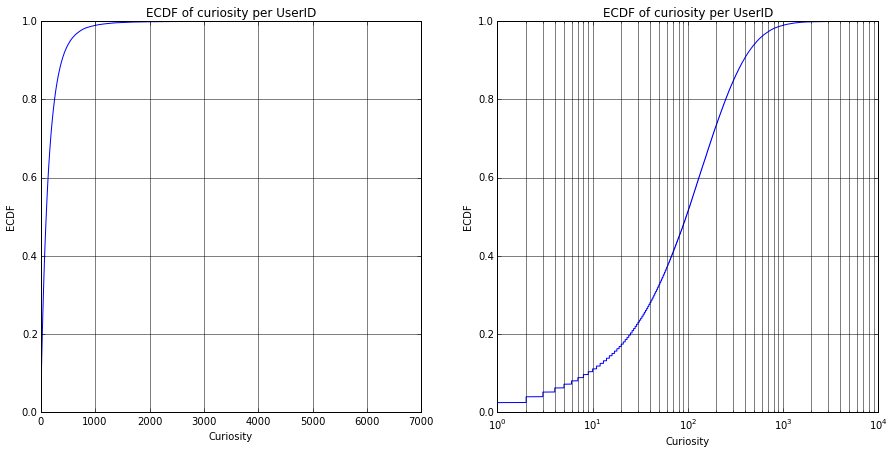

In [122]:
userCuriosity = UsersAS_clean.collect()
#userArtistDF.groupBy('artistID').sum('playCount').limit(5).show()

pdf = pd.DataFrame(data=userCuriosity)
Y=np.sort(pdf[1])
yvals=np.arange(len(Y))/float(len(Y))
print('Percentiles:')
print(pdf.quantile([.0,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.95,.99,1.0])[1])

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot( Y, yvals )
plt.xlabel('Curiosity')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of curiosity per UserID')

plt.subplot(122)
plt.semilogx( Y, yvals )
plt.xlabel('Curiosity')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of curiosity per UserID')
plt.show()

When we look at the chart on the right, we can see that only 1% of the users have listened to more than 1000 artists.
We can also observe that 20% of the users listened less than 25 artists and it could be difficult to make recommendations for them. 

In [123]:
userArtist_cleanDF.show(10)

UsersAS_clean_top100 = ( 
    userArtist_cleanDF
    .drop('playcount')
    .groupBy('userID')
    .count()
    .orderBy(['count','userID'], ascending=0)
    .withColumnRenamed("count", "curiosity")
    .limit(100)
    .select('userID')
)

UsersPC_clean_top100 = ( 
    userArtist_cleanDF
    .groupBy('userID')
    .sum('playCount')
    .orderBy(['sum(playCount)','userID'], ascending=0)
    .limit(100)
    .select('userID') 
)

User_intersectionDF = (
    sqlContext
    .createDataFrame(UsersAS_clean_top100.rdd.intersection(UsersPC_clean_top100.rdd) ,['User Intersection ID'])
)
User_intersectionDF.show()
print('number of intersection in the top 100 per playcount and curiosity',User_intersectionDF.count())

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2064012|    4468|   439771|
|1059637| 1002095|   433060|
|1059637| 1026440|   155895|
|2069889| 1002095|   101076|
|2020513| 1007801|    89592|
|1073421| 1004440|    67548|
|2023977| 1007903|    62815|
|2023977|    2823|    51039|
|2014936|      82|    36083|
|2069337| 1006134|    34800|
+-------+--------+---------+
only showing top 10 rows

+--------------------+
|User Intersection ID|
+--------------------+
|             1043751|
|             1035511|
|             2007573|
|             1022223|
|             1024631|
|             2024005|
|             1073896|
|             1026084|
|             2010008|
|             2016026|
|             1059334|
|             1001440|
|             2023686|
+--------------------+

number of intersection in the top 100 per playcount and curiosity 13


Comparing the top 10 users in terms of playcounts and in terms of curiosity, we obtain an empty table, which means that the two set are disjointed. When we extend the comparison in the top 100 of both values, we obtain 13 users that are both in top 100 per playcount and per curiosity. This means that many users that are in the top 100 per playcount have a low curiosity value, and the same is true for the ones with high curiosity: they listen few times many artists. 

In [124]:
user_play_cur = (
UsersAS_clean
.join(UsersPC_clean, UsersAS_clean.userID == UsersPC_clean.userID, "left_outer")
.drop(UsersPC_clean.userID)
.drop('userID')
.collect()
)

curiosity = [w[0] for w in user_play_cur]
playcount = [w[1] for w in user_play_cur]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


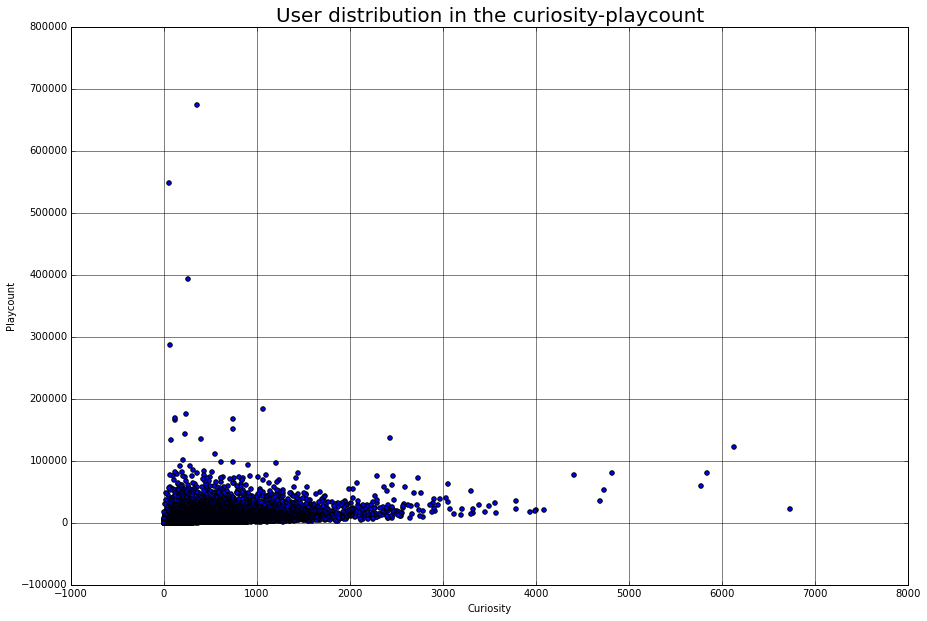

In [125]:
plt.figure(figsize=(15,10))

plt.scatter(curiosity, playcount)
plt.xlabel('Curiosity')
plt.ylabel('Playcount')
plt.grid(True,which="both",ls="-")
plt.title('User distribution in the curiosity-playcount', fontsize=20)

plt.show()

Here we can see the generalization of the analysis done before about the user curiosity-playcount relationship. It's evident that users with high playcount have also a very low curiosity. It's also evident that most of the users are in the area limited by 100000 playcounts and 3000 different artists listened. This means that most of the users have the same behaviour. We should still note that the curiosity value is higher than it should be because of mispelled artists.

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is converged. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we init the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row from $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:

Initialize $X$, $Y$

**while**(convergence is not true) **do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**

For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute 􏰀$\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute 􏰁$\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

```python
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( ... )
    
                    # fileter out the special tuples
                    .filter( ... )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )
```

In [53]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias  # extract fields using function xtractFields
                    .map(xtractFields)
    
                    # fileter out the special tuples
                    .filter(lambda tup : tup != (-1,-1))
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )


#### Question 6.2
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.

HINT: Using broadcast varible can help us increase the effiency.

```python
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias. ...
    return (..., ..., ...)

userArtistDataRDD = rawUserArtistData.map(...)
userArtistDataRDD.take(5)
```

In [54]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def flat(line):
    [userID, artistID, count] = line.split(' ')
    return artistID

def disamb(artistID):
    finalArtistID = bArtistAlias.value.get(int(artistID),int(artistID))
    return str(finalArtistID)

#userArtistDataRDD = rawUserArtistData.map(disambiguate).map(lambda x : x[1])
#print(userArtistDataRDD.distinct().map(disamb).count())


In [55]:
ArtistDataRDD_dirty = rawUserArtistData.map(flat).distinct().cache()
print('Number of distinct artists before any clean: ',ArtistDataRDD_dirty.count())
print('As we can see, the number of artists is the same as calculated using the dataframe')

ArtistDataRDD_clean_1 = ArtistDataRDD_dirty.map(disamb).distinct().cache()
print('Number of distinct artists before first clean: ',ArtistDataRDD_clean_1.count())

ArtistDataRDD_clean_2 = ArtistDataRDD_clean_1.map(disamb).distinct().cache()
print('Number of distinct artists before second clean: ',ArtistDataRDD_clean_2.count())

Number of distinct artists before any clean:  1631028
As we can see, the number of artists is the same as calculated using the dataframe
Number of distinct artists before first clean:  1568126
Number of distinct artists before second clean:  1568117


In [58]:
def split_line(line):
    [userID, artistID, count] = line.split(' ')
    return (userID, artistID, count)

def disamb_2(line):
    finalArtistID_1 = bArtistAlias.value.get(int(line[1]),int(line[1]))
    finalArtistID_2 = bArtistAlias.value.get(int(finalArtistID_1),int(finalArtistID_1))
    return (line[0], str(finalArtistID_2), line[2])

userArtistDataRDD = rawUserArtistData.map(split_line).map(disamb_2).cache()
#print(userArtistDataRDD.take(5))

#print(userArtistDataRDD.map(lambda line : line[1]).distinct().count(),'distinct artists, this is used as a proof that the cleaning works')


In [59]:
def part(line):
    return ((line[0],line[1]),int(line[2]))

def my_pack(line):
    return (line[0][0], line[0][1], str(line[1]))


userArtistDataRDD_final = userArtistDataRDD.map(part).reduceByKey(lambda x,y : x + y).map(my_pack).cache()
userArtistDataRDD_take5 = userArtistDataRDD_final.take(5)

In [60]:
print(userArtistDataRDD_take5)

[('2069960', '1033643', '2'), ('2077373', '1001412', '113'), ('2343111', '733', '31'), ('2348562', '1001479', '1'), ('2161777', '5369', '1')]


## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.

In [132]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

```python
allData = userArtistDataRDD.map(lambda r: Rating(..., ..., ...)).repartition(...).cache()
```

In [62]:
allData = userArtistDataRDD_final.map(lambda r: Rating(r[0],r[1],r[2])).repartition(48).cache()

We tried many repartition values and we have seen that after 12, which is the number of cores that we have, the time needed to train our model remains constant. Actually, we have read that using a value which is 3-4 times the number of cores is optimal, so we used 48.

#### Question 7.2
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
* `training data` is the input data you decide to feed to the ALS algorithm
* `rank` is the number of laten features

We can also use some additional parameters to adjust the quality of the model. Currently, let's set 

- `rank=10`
- `iterations=5`
- `lambda_=0.01`
- `alpha=1.0` 

to build model.

```python
t0 = time()
model = ALS.trainImplicit( ... )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))
```

In [63]:
t0 = time()
model = ALS.trainImplicit(ratings=allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 153.329641 secs


#### Question 7.3
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

```python
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( ... , ...)
```

In [64]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , "lastfm_model.spark")

Deleted lastfm_model.spark


#### Question 7.4
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.

```python
t0 = time()
model = MatrixFactorizationModel.load(..., ...)
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))
```

In [65]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'lastfm_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 0.980635 secs


#### Question 7.5
Print the first row of user features in our model.

```python
model.userFeatures(). ...
```

In [66]:
model.userFeatures().take(1)

[(90,
  array('d', [0.6674767732620239, 1.0309081077575684, -0.01374572329223156, 0.5634956359863281, -0.3563999533653259, -0.7609330415725708, -0.3101719915866852, 0.11530221253633499, -0.394693523645401, 0.30670619010925293]))]

As expected, there are 10 features in the array (rank 10 during training)

### Question 8
Show the top-5 artist names recommendated for user `2093760`.

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

```python
# Make five reccommendations to user 2093760
recommendations = (model. ...)

# construct set of recommendated artists
recArtist = set( ... )
```

```python
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
```

```python
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (...):
        return True
    else:
        return False

recList = artistByID.filter(...).values().collect()

print(recList)
```

In [67]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))
# construct set of recommendated artists
#this is a set of the recommended aritsts
recArtist= set(r[1] for r in recommendations)

In [68]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
#print(artistByID.take(5))

In [69]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda s: artistNames(s) == True).values().collect()

print(recList)

['50 Cent', 'Snoop Dogg', 'Jay-Z', '2Pac', 'The Game']


In [70]:
print('Artists listened by user 2093760:')
(
    userArtist_cleanDF
    .filter(userArtist_cleanDF['userID'] == 2093760)
    .drop(userArtist_cleanDF.playCount)
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .join(ArtistsAS_clean, userArtist_cleanDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .drop(userArtist_cleanDF.userID)
    .show()
)
print('Artists recommended for user 2093760:')
recArtistDF = artistByID.filter(lambda s: artistNames(s) == True).toDF(['artistID','name']).cache()
recArtistDF_withAudience =(
    recArtistDF
    .join(ArtistsAS_clean, recArtistDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
)
recArtistDF_withAudience.show()

Artists listened by user 2093760:
+--------+---------------+-------------+
|artistID|           name|audience_size|
+--------+---------------+-------------+
|     378|  Blackalicious|         4465|
|     813|     Jurassic 5|         8548|
| 1255340|The Saw Doctors|          152|
|     942|         Xzibit|         6069|
|    1180|     David Gray|         7707|
+--------+---------------+-------------+

Artists recommended for user 2093760:
+--------+----------+-------------+
|artistID|      name|audience_size|
+--------+----------+-------------+
| 1001819|      2Pac|        13031|
| 1007614|     Jay-Z|        16447|
| 1300642|  The Game|         7011|
|    2814|   50 Cent|        17062|
|    4605|Snoop Dogg|        16010|
+--------+----------+-------------+



We can see that the model recommends artists of the same genre of the listened ones. Looking at the recommended artists, we can state that generally they are more famous than the listened ones. So the model seems to recommend artists with high audience. Let's see if we have the same behaviour for an other user. 

In [71]:
print('Artists listened by user 1000002:')
artistsListenedByUser1000002 = (
    userArtist_cleanDF
    .filter(userArtist_cleanDF['userID'] == 1000002)
    .drop(userArtist_cleanDF.playCount)
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .join(ArtistsAS_clean, userArtist_cleanDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .drop(userArtist_cleanDF.userID)
)

artistsListenedByUser1000002.show()

print ("The audience size average of the artists listened by user 1000002 is:")
artistsListenedByUser1000002.select('audience_size').groupBy().avg().show()


# Make five reccommendations to user 2093760
recommendations_2 = (model.recommendProducts(1000002,5))
# construct set of recommendated artists
#this is a set of the recommended aritsts
recArtist_2= set(r[1] for r in recommendations_2)


def artistNames_2(line):
#     [artistID, name]
    if (line[0] in recArtist_2):
        return True
    else:
        return False

recList_2 = artistByID.filter(lambda s: artistNames_2(s) == True).values().collect()

print('Top 5 recommended artists:')
recArtistDF_2 = artistByID.filter(lambda s: artistNames_2(s) == True).toDF(['artistID','name']).cache()
(
    recArtistDF_2
    .join(ArtistsAS_clean, recArtistDF_2.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .show()
)

Artists listened by user 1000002:
+--------+--------------------+-------------+
|artistID|                name|audience_size|
+--------+--------------------+-------------+
|    5409|                 AFI|        14296|
| 1003514|          Chuck Loeb|           82|
| 1004346|       Joshua Redman|          323|
|    1224|    Joan Armatrading|          846|
|    3009|         Kula Shaker|         2588|
|    4371|        Lostprophets|        11977|
| 1000674|       Harvey Danger|         3529|
| 1000840|        Lee Ritenour|          246|
| 1003488|       Erroll Garner|          204|
|    2184|         Julian Cope|          743|
|    3327|              Weezer|        31951|
| 1001008|          Buckcherry|         1464|
| 6691692|                渡辺貞夫|           66|
| 1004378|       Marilyn Scott|           20|
| 1052993|               metro|          129|
| 1284697|Benny Goodman & P...|           54|
| 2100785|               ג'נגו|           21|
| 1036431|     Luciano Ligabue|          158|


As we can see the audience of the recommended artists is always greater than the audience of the artists listened by this user

#### IMPORTANT NOTE

At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.

In [137]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:

- rank=10
- iterations=5
- lambda_=0.01
- alpha=1.0

```python
trainData, cvData = allData.randomSplit ...
trainData.cache()
cvData.cache()
```

```python
t0 = time()
model = ALS.trainImplicit( ... )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))
```

In [63]:
trainData, cvData = allData.randomSplit([9,1])
trainData.cache()
cvData.cache()

PythonRDD[1019] at RDD at PythonRDD.scala:48

In [64]:
t0 = time()
model = ALS.trainImplicit(ratings=trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 30.688690 secs


#### Area under the ROC curve: a function to compute it

In [65]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [129]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.

```python
t0 = time()
auc = calculateAUC( ... , ..., model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))
```

In [67]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9685841748617482
finish in 21.016390 seconds


#### Question 9.3
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective. 

Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.

```python
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(...).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( ... , 0.0)))
```

```python
auc = calculateAUC(..., ..., predictMostListened)
print(auc)
```

In [68]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda rate1,rate2: rate1 + rate2).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))

In [69]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)

0.939015517648552


If we compare the auc of the simple model with that of the model obtained using ALS, we can see that ALS wins.

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.

```python
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( ... )
            
            auc = calculateAUC( ... )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( ... )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()
```

In [139]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(ratings=trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [160]:
evaluations.sort(key=lambda table:table[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()
print('the best parameters are: rank=%d lambda=%f alpha=%f ' % (evalDataFrame[0][0][0],evalDataFrame[0][0][1],evalDataFrame[0][0][2]))

                    0         1
0     (10, 1.0, 40.0)  0.976819
1     (50, 1.0, 40.0)  0.976639
2  (50, 0.0001, 40.0)  0.975961
3  (10, 0.0001, 40.0)  0.975530
4      (10, 1.0, 1.0)  0.970187
5      (50, 1.0, 1.0)  0.967288
6   (10, 0.0001, 1.0)  0.965071
7   (50, 0.0001, 1.0)  0.953764
the best parameters are: rank=10 lambda=1.000000 alpha=40.000000 


#### Question 10.2 

Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user 2093760.

```python
model = ALS.trainImplicit( ... )
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(...)

recommendedProductIDs = set( ... )

recList = artistByID. ...
print(recList)

unpersist(model)
```

In [163]:
model = ALS.trainImplicit(ratings=allData, rank=evalDataFrame[0][0][0],iterations=5, lambda_=evalDataFrame[0][0][1],alpha=evalDataFrame[0][0][2])
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID ,5)

recommendedProductIDs =  set([r[1] for r in recommendations]) 
recList = artistByID.filter(lambda s: artistNames(s)==True).values().collect()
print(recList)

['50 Cent', 'Jay-Z', 'Kanye West', '2Pac', 'The Game']


We note that using the best parameters the result does not change for this specific user. Maybe it's quite easy to recommend artists for this user.

Now we would like to plot the user features, but they are too much, thus we train the model setting rank=2

In [229]:
model = ALS.trainImplicit(ratings=allData, rank=2, iterations=5, lambda_=evalDataFrame[0][0][1],alpha=evalDataFrame[0][0][2])
model_2 = ALS.trainImplicit(ratings=allData, rank=2, iterations=5, lambda_=evalDataFrame[0][0][1],alpha=evalDataFrame[0][0][2])
allData.unpersist()

MapPartitionsRDD[5079] at coalesce at NativeMethodAccessorImpl.java:0

In [230]:
features = list(zip(*[prod[1] for prod in model.userFeatures().collect()]))
features_2 = list(zip(*[prod[1] for prod in model_2.userFeatures().collect()]))

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


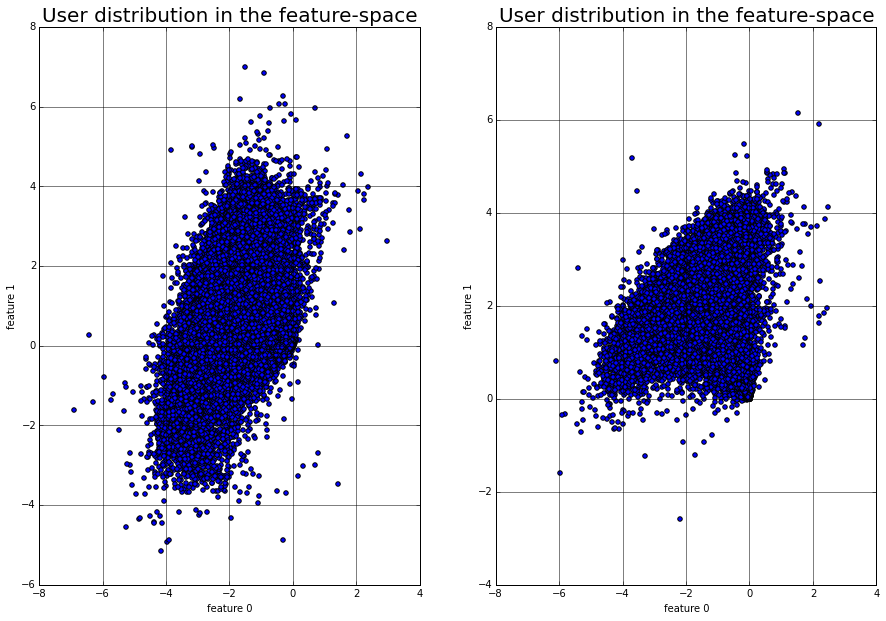

In [233]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.scatter(features[0], features[1])
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.grid(True,which="both",ls="-")
plt.title('User distribution in the feature-space', fontsize=20)


plt.subplot(122)
plt.scatter(features_2[0], features_2[1])
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.grid(True,which="both",ls="-")
plt.title('User distribution in the feature-space', fontsize=20)
plt.show()


We tried to plot the user features in a 2D space in order to look at some pattern, but we verified that every time we train our model we obtain different features. This probably depends from ALS.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)

# Unknown and various artists

During our analysis we have spotted these two artist names that are suspicious. In order to better understand how this can affect our recommendation, we decided to do a more detailed analysis. We specify that these two artists are still in our data after the cleaning phase

In [126]:
import re
pattern_vau = re.compile(r'.*Various|unknown|Artist|Track.*|\[unknown\]', re.IGNORECASE)

userArtistName = (
    userArtist_cleanDF
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID).cache()
) 

ArtistName_filtered = userArtistName.drop('userID').rdd.filter(lambda line : pattern_vau.match(str(line[2]))).toDF(['artistID' ,'playCount','name']).cache()
ArtistName_filtered_grouped = ArtistName_filtered.groupBy('artistID', 'name').sum('playCount').withColumnRenamed("sum(playCount)", "playCount").cache()
ArtistName_filtered_grouped.orderBy('playCount', ascending=0).show(20, truncate=False)

+--------+---------------------------+---------+
|artistID|name                       |playCount|
+--------+---------------------------+---------+
|1034635 |[unknown]                  |429447   |
|393     |Various Artists            |134053   |
|4629    |Unknown                    |16795    |
|10213468|Artista desconhecido       |3410     |
|6631690 |Spain In My Heart (Various)|2365     |
|1322331 |Tracktor Bowling           |2049     |
|1044731 |Unknown Source             |1395     |
|1192790 |Tracker                    |1298     |
|1099733 |Various Classical          |1214     |
|1048037 |Unknown Prophets           |1191     |
|1018255 |Track Star                 |1172     |
|1031391 |Various Composers          |1120     |
|6613024 |Various (Soundtrack)       |1120     |
|6916755 |Unknown Forces             |1001     |
|1060952 |Artista                    |807      |
|10219373|Artistes variés            |668      |
|6669292 |Unknown, zircon            |537      |
|1093423 |Warp Recor

Here we filtered the artists with suspicious names: names that contains 'Various','(Unknown','Artist'. From the resulting table we can see that many of them have a very large play count, in fact thay are above the 95% percentile. This is particularly true for the top 3, which are above the 99% percentile. Looking at the names, we can see that many of them are actually fake names, which can corrupt our recommendation system. Since we do not have a method to filter them without removing legit artist, we decided to remove only the top 3, which have an high play count and they are absolutely fake artist. When we look at other artists in the table, there are some example of artists with suspicious names but actually legit e.g. 'pain In My Heart', 'Unknown Source', 'Unknown Prophets'.

In [127]:
pattern_oasis = re.compile(r'.*oasis.*', re.IGNORECASE)

ArtistName_filtered = userArtistName.drop('userID').rdd.filter(lambda line : pattern_oasis.match(str(line[2]))).toDF(['artistID' ,'playCount','name']).cache()
ArtistName_filtered_grouped = ArtistName_filtered.groupBy('artistID', 'name').sum('playCount').withColumnRenamed("sum(playCount)", "playCount").cache()
ArtistName_filtered_grouped.orderBy('playCount', ascending=0).show(20, truncate=False)

+--------+---------------------------------------------------------+---------+
|artistID|name                                                     |playCount|
+--------+---------------------------------------------------------+---------+
|1259    |Oasis                                                    |605582   |
|6865191 |Oasis_Various                                            |469      |
|10078008|Green Day vs. Oasis vs. Travis vs. Eminem & Aerosmith    |214      |
|10006634|Green Day vs. Oasis vs. Travis (vs. Aerosmith) vs. Eminem|180      |
|6912244 |Green Day vs. Oasis vs. Travis vs. Eminem                |135      |
|1018820 |Oasis with Paul Weller                                   |129      |
|1350280 |Oasis & Robbie Williams                                  |120      |
|1278325 |DJ Oasis                                                 |111      |
|10709378|Oasis - Dont believe the Truth                           |109      |
|10500926|Greenday vs Oasis vs Travis vs Eminem     

Here we filtered artists that match the name 'oasis'. We can see that many of them are actually feats with other artists, while only the second should be joined in the original artist. Regarding the feats, we don't know if they should be counted in the main artist or not. Since we do not have a confident way to join these artists, we do not do nothing.

In [128]:
#filter 
userArtistName_filtered = (
userArtistName.filter((userArtistName.artistID!='1034635') & (userArtistName.artistID!='393') & (userArtistName.artistID!='4629') & (userArtistName.artistID!='10213468')&(userArtistName.artistID!='1000239')).cache()
.drop('name')
)

We thought that maybe the artists with very low playCounts and audience could be spurious data like songs or radio or in general something that is not a a band or a singer. So we thought interesting to show the names of these aristis.

In [77]:
print('Here the artists with the lower audience size:')
ArtistsAS_clean.orderBy('audience_size', ascending=1).show(20, truncate=False)

Here the artists with the lower audience size:
+--------+----------------------------------------------------+-------------+
|artistID|name                                                |audience_size|
+--------+----------------------------------------------------+-------------+
|1032195 |Justin T. and Kylie M.                              |1            |
|1024248 |Gong Shapeshifter 12 Can Yo                         |1            |
|1031729 |mysterious Cambodian band                           |1            |
|1008612 |Mary Bue                                            |1            |
|1023669 |M.M.Bosstones                                       |1            |
|1027912 |Professional Sntk                                   |1            |
|1031336 |(03) Ultraspank                                     |1            |
|1000061 |Capdown (Bollucks is it)                            |1            |
|1007893 |Jonn Serrie Midsummer Century Distant Moment (Axioms|1            |
|1012072 |Zevon/H

In [78]:
print('Here the artists with the lower associated playcounts:')
ArtistsPC_clean.orderBy('sum(playCount)', ascending=1).show(20, truncate=False)

Here the artists with the lower associated playcounts:
+--------+--------------------------------------------------------------+--------------+
|artistID|name                                                          |sum(playCount)|
+--------+--------------------------------------------------------------+--------------+
|1050233 |Where the Heart Is Soundtrack                                 |1             |
|1033378 |very funn                                                     |1             |
|1047610 |Bobby Leecan and Robert Cooksey                               |1             |
|1027912 |Professional Sntk                                             |1             |
|1032195 |Justin T. and Kylie M.                                        |1             |
|1040019 |dj spooky that subliminal kid vs. the freight elevator quartet|1             |
|1046601 |NateFeat Warren G                                             |1             |
|1021122 |everybody sexareeno!                         

As we can note from the tables below there are a lot of fake names, mispelled strings, featurings, songs. However sometimes there are names that seem clean so a complete removal is not a good approach because we would delete almost 60% of the artists. Later we have seen that our model is still good also with this dirty data.

In [79]:
allData_filtered = userArtistName_filtered.rdd.map(lambda r: Rating(r[0],r[1],r[2])).repartition(48).cache()

In [76]:
trainData_filtered, cvData_filtered = allData_filtered.randomSplit([9,1])
trainData_filtered.cache()
cvData_filtered.cache()

PythonRDD[1285] at RDD at PythonRDD.scala:48

In [77]:
allItemIDs = np.array(allData_filtered.map(lambda x: x[1]).distinct().collect())
print(allItemIDs[0:5])
bAllItemIDs = sc.broadcast(allItemIDs)

[10616832  1277952 10084224 10385376 10535952]


In [258]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(ratings=trainData_filtered, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC( cvData_filtered, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [259]:
evaluations.sort(key=lambda table:table[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData_filtered.unpersist()
cvData_filtered.unpersist()
evalDataFrame[0][0]

                    0         1
0     (10, 1.0, 40.0)  0.977152
1     (50, 1.0, 40.0)  0.976802
2  (10, 0.0001, 40.0)  0.976594
3  (50, 0.0001, 40.0)  0.975720
4      (10, 1.0, 1.0)  0.969548
5      (50, 1.0, 1.0)  0.967503
6   (10, 0.0001, 1.0)  0.966541
7   (50, 0.0001, 1.0)  0.954540


(10, 1.0, 40.0)

In [260]:
t0 = time()
model_1 = ALS.trainImplicit(ratings=allData_filtered,rank=evalDataFrame[0][0][0],iterations=5,lambda_=evalDataFrame[0][0][1],alpha=evalDataFrame[0][0][2])

t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 19.224348 secs


In [261]:
recommendations_1 = (model_1.recommendProducts(2093760,5))
# construct set of recommendated artists
#this is a set of the recommended aritsts
recArtist_1= set(r[1] for r in recommendations_1)


print(recArtist_1)


def artistNames_1(line):
#     [artistID, name]
    if (line[0] in recArtist_1):
        return True
    else:
        return False

recList_1 = artistByID.filter(lambda s: artistNames_1(s) == True).values().collect()

print(recList_1)

{1058104, 930, 1001819, 1007614, 2814}
['50 Cent', 'Jay-Z', '2Pac', 'Eminem', 'Gwen Stefani']


As we can see, the model trained with the data filtered recommends different artists than before. The new artists suggested are Eminem and Gwen Stefani. They are still famous artist of rap/hip-hop genre.

# INVERSE PLAYCOUNT MODEL

The big question is: when does lastfm register a playcount as effective? For example, if a user listen for 10 seconds a song and then he skips it, than we have a playcount or not?
Unfortunately we have not found the answer, but we have the answer from another music company: Spotify.
A song, in order to count, needs to be listened for 30 seconds.
If this is also true for our dataset, it meance that a user playcount equal to 1 meance that the user listened the song one time for at least 30 seconds, and probably liked it. This is fundamental for what we are going to do.

We want to recommend artists related to those that the user listened few times. We Think that in this way we can explore in a better way the artist catalogue.

In order to achieve this, since we do not have other data different from playcounts and matching a genre with an artist is not very easy, we decided to use the playcounts that we have in another way.
ALS is able to factor our rating matrix, but at the end, the recommendations depend on the ratings that we put in the matrix. What if we change that kind of data? Maybe we change recommendation. We did this by replacing each playcount with its inverse, in this way artists with high playcount have a bad score and artist with low playcount have an high score. We don't know what are the consequences of using ALS with different values and how we should this. (calculating the inverse completely change di playcount distribution)

In [93]:
allData_inverse = userArtistName_filtered.rdd.map(lambda r: Rating(r[0],r[1],str(5/int(r[2])))).repartition(12).cache()
print(allData_inverse.take(5))

[Rating(user=2190001, product=26, rating=0.625), Rating(user=2237761, product=26, rating=0.7142857142857143), Rating(user=1026084, product=26, rating=0.7142857142857143), Rating(user=1061434, product=26, rating=0.7142857142857143), Rating(user=2040688, product=26, rating=0.7142857142857143)]


In [94]:
trainData_inverse, cvData_inverse = allData_inverse.randomSplit([9,1])
trainData_inverse.cache()
cvData_inverse.cache()

PythonRDD[1497] at RDD at PythonRDD.scala:48

In [95]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
print(allItemIDs[0:5])
bAllItemIDs = sc.broadcast(allItemIDs)

[ 6881280  2162688 10234800 10385376 10686528]


In [96]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(ratings=trainData_inverse, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC( cvData_inverse, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [97]:
evaluations.sort(key=lambda table:table[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData_inverse.unpersist()
cvData_inverse.unpersist()
print('the best parameters are: rank=%d lambda=%f alpha=%f ' % (evalDataFrame[0][0][0],evalDataFrame[0][0][1],evalDataFrame[0][0][2]))

                    0         1
0      (50, 1.0, 1.0)  0.979985
1     (10, 1.0, 40.0)  0.979467
2     (50, 1.0, 40.0)  0.979036
3  (10, 0.0001, 40.0)  0.978913
4      (10, 1.0, 1.0)  0.977786
5  (50, 0.0001, 40.0)  0.977683
6   (10, 0.0001, 1.0)  0.966469
7   (50, 0.0001, 1.0)  0.953093
the best parameters are: rank=50 lambda=1.000000 alpha=1.000000 


In [98]:
t0 = time()
model_1 = ALS.trainImplicit(ratings=allData_inverse,rank=evalDataFrame[0][0][0],iterations=5,lambda_=evalDataFrame[0][0][1],alpha=evalDataFrame[0][0][2])

t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 88.462468 secs


In [99]:
recommendations_1 = (model_1.recommendProducts(2093760,5))
# construct set of recommendated artists
#this is a set of the recommended aritsts
recArtist= set(r[1] for r in recommendations_1)


print(recArtist)


def artistNames_1(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda s: artistNames_1(s) == True).values().collect()

print(recList)

{3656, 4569, 250, 1306, 1002470}
['The Verve', 'No Doubt', 'Simon & Garfunkel', 'Elton John', 'Outkast']


In [100]:
print('Artists listened by user 2093760:')
(
    userArtist_cleanDF
    .filter(userArtist_cleanDF['userID'] == 2093760)
    .drop(userArtist_cleanDF.playCount)
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .join(ArtistsAS_clean, userArtist_cleanDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .drop(userArtist_cleanDF.userID)
    .show()
)

print('Artists recommended for user 2093760:')
recArtistDF = artistByID.filter(lambda s: artistNames(s) == True).toDF(['artistID','name']).cache()
(
    recArtistDF
    .join(ArtistsAS_clean, recArtistDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .show()
)

Artists listened by user 2093760:
+--------+---------------+-------------+
|artistID|           name|audience_size|
+--------+---------------+-------------+
|     378|  Blackalicious|         4465|
|     813|     Jurassic 5|         8548|
| 1255340|The Saw Doctors|          152|
|     942|         Xzibit|         6069|
|    1180|     David Gray|         7707|
+--------+---------------+-------------+

Artists recommended for user 2093760:
+--------+-----------------+-------------+
|artistID|             name|audience_size|
+--------+-----------------+-------------+
|     250|          Outkast|        24774|
| 1002470|       Elton John|        14965|
|    1306|        The Verve|        12979|
|    3656|         No Doubt|        20787|
|    4569|Simon & Garfunkel|        19887|
+--------+-----------------+-------------+



It seems that the recommender system recommends famous artists, but with a different genre: this looks plausible because we penalize artists that the user listen often and we try to recommend artist that the user listened few times. In this case, 'The Verve', 'No Doubt' and 'Simon & Garfunkel', which are rock artists, match the genre of 'The Saw Doctors', a rock artist that the user listened few times. We think that the recommendation engine works. 

# AUDIENCE BASED MODEL

As we have written before, the model generally proposes artists with an high audience. Our idea was to balance this behaviour looking at the artist audience. Every user listened many artists, each one with a different audience, so every user has associated different audience values, one for each listened artist. Computing the average or the median of these audience values, it's possibile to obtain  a new measure associated to the user that should express which is the popularity of the artists that he listens to. If this value is low, the user usually plays  "underground" music, at the opposite, if the value is high, the user plays "mainstream" music. Keeping this into account, we want try to build a model that recommends "underground" songs to the users that usually plays less popular artists and "commercial" songs to the users that usually plays more popular artists. Actually our idea is to start with the base recommendation method based on the playcount, penalizing the recommended artists that has a different audience respect to the median value (or mean avalue) audience associated to the user.

Let's start! All the model will be tested using the new cleaned data, without "unknown" and spurious artists.

In [101]:
userArtist_cleanDF = userArtistName_filtered
TOTAL_ARTISTS_NUMBER = userArtist_cleanDF.select('artistID').distinct().count()

In [104]:
MAX_playcount= float(userArtist_cleanDF.agg({"playCount": "max"}).collect()[0][0])
print(MAX_playcount)

Users_artists_audience = ( 
    userArtist_cleanDF
    .join(ArtistsAS_clean,userArtist_cleanDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .cache()
    
)

Users_artists_audience.show(5)

Users_audience_mean = (
    Users_artists_audience
    .select('userID','audience_size')
    .groupBy('userID')
    .avg('audience_size')
    .withColumnRenamed("avg(audience_size)", "audience_mean")
    .cache()
)

Users_audience_mean.show(5)

439771.0
+-------+---------+--------+-------------+-------------+
| userID|playCount|artistID|         name|audience_size|
+-------+---------+--------+-------------+-------------+
|1067932|      174|      26|Barry Adamson|         1132|
|2241392|      116|      26|Barry Adamson|         1132|
|1066803|      112|      26|Barry Adamson|         1132|
|2171854|      105|      26|Barry Adamson|         1132|
|2376555|       87|      26|Barry Adamson|         1132|
+-------+---------+--------+-------------+-------------+
only showing top 5 rows

+-------+------------------+
| userID|     audience_mean|
+-------+------------------+
|2061120|1874.8306569343065|
|2025959| 4362.404669260701|
|2293749|3358.5840455840457|
|1056146| 7061.093632958801|
|2080232| 3222.328703703704|
+-------+------------------+
only showing top 5 rows



The code above shows how to obtain a table in which an audience_mean is associated to every user. However we though that the audience mean is not a good measure because is sensitive to the outliers, so in the code below we created a different table (user, audience_median).

In [106]:
import numpy
Users_audience = Users_artists_audience.select('userID','audience_size')

def compute_median(line):
    median=float((numpy.median(numpy.array(line[1]))))
    return (line[0],median)
    
Users_audience_median = (
    Users_audience
    .groupBy('userID')
    .agg(collect_list("audience_size"))
    .withColumnRenamed("collect_list(audience_size)", "audience_arr")
    .rdd.map(compute_median).toDF(['userID','audience_median'])
    .cache()
)

Users_audience_median.show(10)


+-------+---------------+
| userID|audience_median|
+-------+---------------+
|1000061|          687.0|
|1000070|         8936.0|
|1000313|         7757.0|
|1000832|          143.5|
|1000905|         2970.5|
|1001372|         2680.0|
|1001409|         1664.0|
|1001530|          282.5|
|1001700|         5902.5|
|1001731|          356.0|
+-------+---------------+
only showing top 10 rows



After computing the median we train the model as before.

In [107]:
t0 = time()
model_1 = ALS.trainImplicit(ratings=allData_filtered, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 47.202203 secs


It's time to indroduce a new function:"compute_recommendation". This function starts with the original recommendation retrieving all the ratings associated with an user and computing the new raitings subtracting the audience_distance (a value that express how much an artist audience is different from the user audience median value) to the previous one. The audience_distance is weighted: if the weight is 0 the new recommendation will be identical to the previous one because the new variable will not have any impact. At the opposite, bigger is the weight, bigger is the impact of this new variable.

In the cell below there is the function code, with comments to explain it.

In [108]:
def compute_recommendation(userID,n_top,w):
    #userID is the identifier of the user for which we want to perform the recommendation
    #n_top is the number of recommendation items we want to visualize, ordered by ratings
    #w is the value of the weight
    recommendations= sqlContext.createDataFrame(model_1.recommendProducts(userID,TOTAL_ARTISTS_NUMBER), ['userID','artistID','Rating_PlayCount'])
    MAX_rating_playcount= recommendations.agg({"Rating_PlayCount": "max"}).collect()[0][0]
    
    #the recommendations_AS dataframe is a new table formed by tuples like this (userID,playCount,artistID,audience_size)
    recommendations_AS = ( 
        recommendations
        .join(ArtistsAS_clean,recommendations.artistID == ArtistsAS_clean.artistID, "left_outer")
        .drop(recommendations.artistID)
        .cache()

    )
    
    
    already_listened_artists =  userArtist_cleanDF.filter(userArtist_cleanDF['userID'] == 2093760).select('userID').collect()

    # below the function to compute the audience deviation given the audience median value and the audience associated
    # to each recommended artist for the considered user.
    # The audience_difference is high when the artist listened by the user has a popularity different from the popularity
    # of the artists that the user normally listens to. So higher this value is, low the rating in the recommendation model
    # should be. 
    
    def audience_dist(line):
        audience_dist = line[0] - line[5]
        if audience_dist < 0:
            audience_dist = audience_dist * -1
        return (line[1],line[3],line[2],audience_dist)

    Users_recommendation_median_dist = (
        Users_audience_median
        .filter(Users_audience_median['userID'] == userID)
        .join(recommendations_AS, Users_audience_median.userID == recommendations_AS.userID, "left_outer")
        .drop(Users_audience_median.userID )
        .rdd.map(audience_dist).toDF(['userID','artistID','rating_playcount','audience_distance'])
        .cache()   
    )
    

    MAX_median_dist= float(Users_recommendation_median_dist.agg({"audience_distance": "max"}).collect()[0][0])
    
    # To compute the final rating we have to subract the audience_distance to the playcount.
    # However the playcount raiting scale has a different range of value compared to the audience_difference.
    # So the code below is useful to change the audience_similarity range of values to make this similar to 
    # the playcount range of values. The compute_new_rating function performs these two steps

    def compute_new_rating(line):
        diff =  MAX_rating_playcount* line[3]/MAX_median_dist
        new_rating = line[2] - w*diff
        return (line[0],line[1],new_rating,line[3])


    Users_recommendation_final  = (
        Users_recommendation_median_dist
        .rdd.map(compute_new_rating).toDF(['userID','artistID','new_rating','audience_distance'])
        .orderBy('new_rating', ascending=0)
        .cache()   
    )   
    # at the end we return the new top-n recommended artists 
    return Users_recommendation_final.select('artistID','new_rating','audience_distance').limit(n_top)

In [109]:
new_recommendation = compute_recommendation(2093760,5,0.5)

print('Artists recommended for user 2093760 with associated audience size and audience_distance:')
(
    new_recommendation
    .join(ArtistsAS_clean, new_recommendation.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .orderBy('new_rating', ascending=0)
    .show()
)

print("Remember! This were the predicted artists using the simple model")

recArtistDF_withAudience.show()

print("and here the already listended artists with related audience size")
(
    userArtist_cleanDF
    .filter(userArtist_cleanDF['userID'] == 2093760)
    .drop(userArtist_cleanDF.playCount)
    .join(artistDF, userArtist_cleanDF.artistID == artistDF.artistID, "left_outer")
    .drop(artistDF.artistID)
    .join(ArtistsAS_clean, userArtist_cleanDF.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .drop(ArtistsAS_clean.name)
    .drop(userArtist_cleanDF.userID)
    .show()
)

Artists recommended for user 2093760 with associated audience size and audience_distance:
+--------+--------------------+-----------------+----------------+-------------+
|artistID|          new_rating|audience_distance|            name|audience_size|
+--------+--------------------+-----------------+----------------+-------------+
| 1300642|0.026596620564814915|            942.0|        The Game|         7011|
| 1003249|  0.0242157141765418|           4300.0|        Ludacris|        10369|
|     829| 0.02411642091931513|           3895.0|             Nas|         9964|
|     942| 0.02380024177607018|              0.0|          Xzibit|         6069|
| 1004028| 0.02345033708195774|           1141.0|Notorious B.I.G.|         7210|
+--------+--------------------+-----------------+----------------+-------------+

Remember! This were the predicted artists using the simple model
+--------+--------+-------------+
|artistID|    name|audience_size|
+--------+--------+-------------+
| 1003249|Lud

As we can see, the new recommended artists have an audience_size value nearer to the median value (for this user 6069).
However there is a problem because an already listened user is recommended ("Xzibit"). However we can filter the artists that the user already listened.

But let's test the new model with a different weight. 

In [111]:
new_recommendation = compute_recommendation(2093760,5,5)

print('Artists recommended for user 2093760 with associated audience size and audience_distance:')
(
    new_recommendation
    .join(ArtistsAS_clean, new_recommendation.artistID == ArtistsAS_clean.artistID, "left_outer")
    .drop(ArtistsAS_clean.artistID)
    .orderBy('new_rating', ascending=0)
    .show()
)

Artists recommended for user 2093760 with associated audience size and audience_distance:
+--------+--------------------+-----------------+--------------------+-------------+
|artistID|          new_rating|audience_distance|                name|audience_size|
+--------+--------------------+-----------------+--------------------+-------------+
|     942| 0.02380024177607018|              0.0|              Xzibit|         6069|
| 1300642| 0.02371242832704949|            942.0|            The Game|         7011|
| 1253195|0.021453356699027745|            290.0|Lil Jon & The Eas...|         5779|
|    3106|0.021004429463998685|              8.0|           Sean Paul|         6061|
| 1004496| 0.02080510259984792|            218.0|            Ice Cube|         5851|
+--------+--------------------+-----------------+--------------------+-------------+



As we can see, increasing the weight value, the deviation from the audience median value has a bigger impact, as we expected. 

At the opposite, setting the weight equals to 0, we will have the same prediction as the base model. So playing with the weight, we can change the final result.

But what can we do also? 
Changing the sign of audience_distance, we can obtain the opposite result: to suggest to the users tha usually listen "underground" music some "mainstream" songs and the opposite. It could be with a different intention: to help expoloring more. At the opposite our original approach has a more conservative impact.

In addition to retrieve informations about music style could be a good improvement. We think that it is possible to retrieve some informations by DBpedia, however this process will rewuire a lot of time. It's also important to say that a prediction absed only on the music style is not good. In fact generally the music rivalries are between artists of the same genre.

# Crossvalidation and configuration optimization 

Running different times ALS we have seen that the result is never the same. This is due to internal aproximations of ALS, but also to the fact that our training and validation set change every time. We need a way to select in a deterministic way our model parameters.
The answer is crossvalidation, but there are many types of crossvalidations. The most common are k-fold and Monte Carlo.

Each method has its own advantages and disadvantages. Under cross validation, each point gets tested exactly once, which seems fair. However, cross-validation only explores a few of the possible ways that your data could have been partitioned. Monte Carlo lets you explore somewhat more possible partitions, though you're unlikely to get all of them.

Here we decided to use Monte Carlo because it's easier to implement in a distributed system.

In [85]:
allData_filtered = userArtistName_filtered.rdd.map(lambda r: Rating(r[0],r[1],r[2])).repartition(48).cache()

In [86]:
allItemIDs = np.array(allData_filtered.map(lambda x: x[1]).distinct().collect())
print(allItemIDs[0:5])
bAllItemIDs = sc.broadcast(allItemIDs)

[ 6881280 10518528 10084224 10385376 10535952]


In [ ]:
num_split = 2

evaluations = []
t0  = time()
for it in range(num_split):
    trainData_filtered, cvData_filtered = allData_filtered.randomSplit([8,2])
    trainData_filtered.cache()
    cvData_filtered.cache()
    
    for rank in [5,10,25,40]:
        for lambda_ in [1.0, 0.01,0.001, 0.0001]:
            for alpha in [1.0, 20.0, 40.0]:
                print("Train model with rank=%d lambda_=%f alpha=%f, it=%d" % (rank, lambda_, alpha, it))
                # with each combination of params, we should run multiple times and get avg
                # for simple, we only run one time.
                t2  = time()
                model = ALS.trainImplicit(ratings=trainData_filtered, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
                auc = calculateAUC( cvData_filtered, bAllItemIDs, model.predictAll )
                t3  = time()
                evaluations.append(((rank, lambda_, alpha, it, t3-t2), auc))
                unpersist(model)
                print("finish training of model in %f secs" % (t3 - t2))
                print("Auc of trained model is %f" % auc)
    trainData_filtered.unpersist()
    cvData_filtered.unpersist()
    

t1 = time()
print("finish training in %f secs" % (t1 - t0))
   

Train model with rank=5 lambda_=1.000000 alpha=1.000000, it=0
finish training of model in 54.992420 secs
Auc of trained model is 0.969923
Train model with rank=5 lambda_=1.000000 alpha=20.000000, it=0
finish training of model in 40.100281 secs
Auc of trained model is 0.973570
Train model with rank=5 lambda_=1.000000 alpha=40.000000, it=0
finish training of model in 39.962695 secs
Auc of trained model is 0.970754
Train model with rank=5 lambda_=0.010000 alpha=1.000000, it=0
finish training of model in 39.157573 secs
Auc of trained model is 0.968302
Train model with rank=5 lambda_=0.010000 alpha=20.000000, it=0
finish training of model in 39.007560 secs
Auc of trained model is 0.971190
Train model with rank=5 lambda_=0.010000 alpha=40.000000, it=0
finish training of model in 41.287128 secs
Auc of trained model is 0.973174
Train model with rank=5 lambda_=0.001000 alpha=1.000000, it=0
finish training of model in 39.314432 secs
Auc of trained model is 0.968194
Train model with rank=5 lambda

In [92]:
eval_tup = [list((*x[0],x[1])) for x in evaluations]

In [93]:
evalDF = sqlContext.createDataFrame(eval_tup, ['rank', 'lambda','alpha','it','time','auc'])
evalDF.toPandas().to_csv('myeval.csv')
eval_avgDF = evalDF.drop('it').drop('time').groupBy(['rank', 'lambda','alpha']).avg('auc')
#eval_avgDF.show()
eval_avgDF.toPandas().to_csv('myeval_avg.csv')

+----+------+-----+------------------+
|rank|lambda|alpha|          avg(auc)|
+----+------+-----+------------------+
|  25|1.0E-4| 40.0|0.9746723732810352|
|  40|1.0E-4|  1.0|0.9518635302758107|
|   5|   1.0| 20.0|0.9737866266253347|
|  40| 0.001|  1.0|0.9516883345754839|
|  10|  0.01| 40.0|0.9744238712320558|
|  10|   1.0|  1.0|0.9674138705934625|
|  25|   1.0|  1.0|0.9652881244838396|
|   5| 0.001|  1.0|0.9669973082636184|
|  25| 0.001| 20.0|0.9719092765669555|
|  40|1.0E-4| 40.0|0.9736890424566946|
|  25|  0.01|  1.0| 0.957308324720267|
|   5|  0.01|  1.0|0.9681537384162767|
|  25| 0.001| 40.0|0.9748137812112151|
|  10| 0.001| 40.0|0.9741302659248974|
|  10|  0.01|  1.0|0.9628011161639782|
|   5|1.0E-4|  1.0|0.9681923982418017|
|  10|1.0E-4| 20.0|0.9726475393444091|
|  40| 0.001| 40.0|0.9736862685346273|
|  25|  0.01| 40.0|0.9748606423066525|
|  10|1.0E-4|  1.0|0.9612723402686721|
+----+------+-----+------------------+
only showing top 20 rows



In [17]:
from_csv = pd.read_csv('myeval.csv')
#from_csv.head()
evalDF = sqlContext.createDataFrame(from_csv).drop('Unnamed: 0')
#evalDF.show()

In [74]:
eval_avgDF = (
    evalDF.drop('it')
    .groupBy(['rank','lambda','alpha'])
    .avg('auc','time')
    .orderBy('avg(auc)',ascending=0)
)
eval_avgDF.show()

+----+------+-----+------------------+------------------+
|rank|lambda|alpha|          avg(auc)|         avg(time)|
+----+------+-----+------------------+------------------+
|  10|   1.0| 40.0|0.9762491409164824|43.641204595565796|
|  25|   1.0| 40.0| 0.975938021980547| 62.50081324577332|
|  40|   1.0| 40.0|0.9751123892551702| 86.87574696540833|
|  25|  0.01| 40.0|0.9748606423066525| 60.00385916233063|
|  25| 0.001| 40.0|0.9748137812112152| 59.68818247318268|
|  10|1.0E-4| 40.0|0.9747585054313298|43.641626596450806|
|  25|1.0E-4| 40.0|0.9746723732810352|  65.6326550245285|
|  10|  0.01| 40.0|0.9744238712320559| 45.76282560825348|
|  10| 0.001| 40.0|0.9741302659248974| 44.35489344596863|
|   5| 0.001| 40.0|0.9739988442732825|42.947850584983826|
|   5|  0.01| 40.0| 0.973897272447475| 40.12887907028198|
|   5|   1.0| 20.0|0.9737866266253348| 40.67107427120209|
|  25|   1.0| 20.0|0.9736943539538554| 60.59527313709259|
|  10|   1.0| 20.0|0.9736899599873934| 45.74229156970978|
|  40|1.0E-4| 

Here we ordered our configuration by the best auc value and we found that when lambda=1.0 and alpha=40.0 we obtain the best results.

In [75]:
eval_time_rank = (
eval_avgDF.drop('avg(auc)','lambda','alpha').collect()
)
eval_time_lambda = (
eval_avgDF.drop('avg(auc)','rank','alpha').collect()
)
eval_time_alpha = (
eval_avgDF.drop('avg(auc)','rank','lambda').collect()
)

In [79]:
rank = [w[0] for w in eval_time_rank]
time = [w[1] for w in eval_time_rank]
lambda_ = [w[0] for w in eval_time_lambda]
alpha = [w[0] for w in eval_time_alpha]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


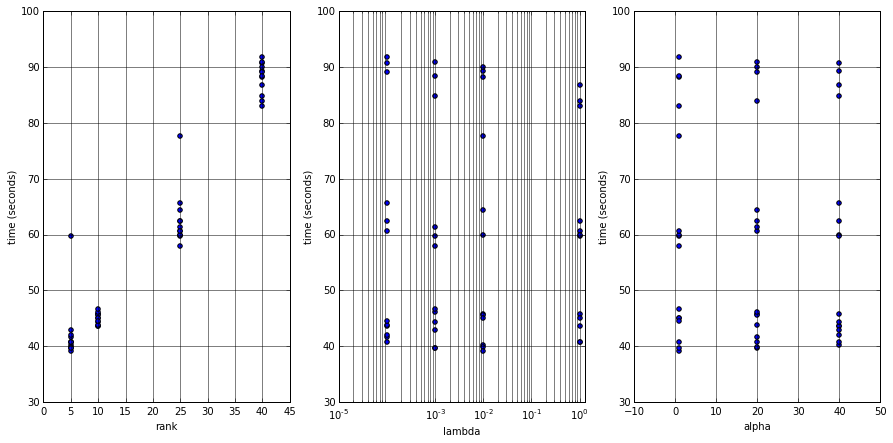

In [77]:
plt.figure(figsize=(15,7))
#plt.title(' space', fontsize=20)

plt.subplot(131)
plt.scatter(rank, time)
plt.xlabel('rank')
plt.ylabel('time (seconds)')
plt.grid(True,which="both",ls="-")


plt.subplot(132)
plt.scatter(lambda_, time)
plt.xlabel('lambda')
plt.ylabel('time (seconds)')
plt.xscale('log')
plt.xlim([0.00005,1.3])
plt.xticks([0.00001,0.001,0.01,0.1,1.0])
plt.grid(True,which="both",ls="-")


plt.subplot(133)
plt.scatter(alpha, time)
plt.xlabel('alpha')
plt.ylabel('time (seconds)')
plt.grid(True,which="both",ls="-")


plt.show()

Here we plotted the training time in function of the learning parameters.
For each value of the parameters we have many points because they refer to different combinations of the other parameters that are not plotted.

For what concerns the rank, we see a clear relation between time and rank value: the training time is higher when the rank increases.

For what concerns the lambda value, the training time is independent from this value.

For what concerns the alpha value, the training time is independent from this value.

In [70]:
eval_auc_rank = (
eval_avgDF.drop('avg(time)','lambda','alpha').collect()
)
eval_auc_lambda = (
eval_avgDF.drop('avg(time)','rank','alpha').collect()
)
eval_auc_alpha = (
eval_avgDF.drop('avg(time)','rank','lambda').collect()
)

In [71]:
rank = [w[0] for w in eval_auc_rank]
time = [w[1] for w in eval_auc_rank]
lambda_ = [w[0] for w in eval_auc_lambda]
alpha = [w[0] for w in eval_auc_alpha]

print(rank)


[25, 40, 5, 40, 10, 10, 25, 5, 25, 40, 25, 5, 25, 10, 10, 5, 10, 40, 25, 10, 5, 40, 10, 40, 40, 40, 5, 5, 25, 25, 5, 25, 10, 25, 40, 5, 25, 5, 40, 25, 40, 10, 5, 40, 10, 10, 10, 5]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


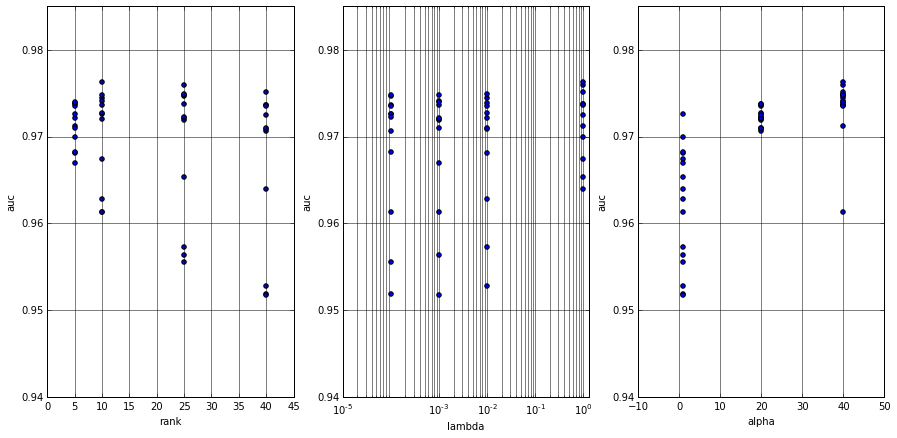

In [72]:
plt.figure(figsize=(15,7))
#plt.title(' space', fontsize=20)

plt.subplot(131)
plt.scatter(rank, time)
plt.xlabel('rank')
plt.ylabel('auc')
plt.grid(True,which="both",ls="-")


plt.subplot(132)
plt.scatter(lambda_, time)
plt.xlabel('lambda')
plt.ylabel('auc')
plt.xscale('log')
plt.xlim([0.00005,1.3])
plt.xticks([0.00001,0.001,0.01,0.1,1.0])
plt.grid(True,which="both",ls="-")


plt.subplot(133)
plt.scatter(alpha, time)
plt.xlabel('alpha')
plt.ylabel('auc')
plt.grid(True,which="both",ls="-")


plt.show()

Here we plotted the auc value in function of the learning parameters.

For what concerns the rank, we do not see a clear relation between auc and rank value. We see that there is a big improvement concerning the auc when we pass from rank=5 to rank=10. Actually, the improvement is visible only in some configurations of the other parameters. When the rank increases, the max auc in each group remain stable, while the worst value always decreases.

For what concerns the lambda value, the training time is independent from this value. We see a general improvement regarding the max value and the average value in the subgroup when we set lambda=1

For what concerns the alpha value, the auc increases when alpha increases. We don't know what happens when we use alpha values greater that 40.

General consideration about the crossvalidation phase:

From our data we obtained that the best parameters are: rank=10, lambda=1.0, alpha=40.0
We have also seen that with this parameters the training time is acceptable:43 seconds.

In order to improve our parameter choice we should run the crossvalidation using more splits in order to have less uncertainty in our results, and we should look at parameter values that are near the best ones that we have found so far.

Since our best values are the same found in the previous phase, we do not train again our model to look at different recommendations

# Crossvalidation split analysis

Here we want to analyse how the splitting of our data influences the performances and the results of the training

In [134]:
allData_filtered = userArtistName_filtered.rdd.map(lambda r: Rating(r[0],r[1],r[2])).repartition(48).cache()

In [135]:
allItemIDs = np.array(allData_filtered.map(lambda x: x[1]).distinct().collect())
print(allItemIDs[0:5])
bAllItemIDs = sc.broadcast(allItemIDs)

[ 2162688  1277952 10084224 10385376 10535952]


In [139]:
num_split = 2
splits = [(9,1),(8,2),(7,3),(6,4),(5,5)]
evaluations = []
t0  = time()
for it in range(num_split):
    for spl in splits:
        trainData_filtered, cvData_filtered = allData_filtered.randomSplit(spl)
        trainData_filtered.cache()
        cvData_filtered.cache()

        print("Train model with training = %d, validation = %d " % (spl[0],spl[1]))

        t2  = time()
        model = ALS.trainImplicit(ratings=trainData_filtered, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
        auc = calculateAUC( cvData_filtered, bAllItemIDs, model.predictAll )
        t3  = time()
        evaluations.append(((it, t3-t2,*spl), auc))
        unpersist(model)
        print("finish training of model in %f secs" % (t3 - t2))
        print("Auc of trained model is %f" % auc)
        trainData_filtered.unpersist()
        cvData_filtered.unpersist()
    

t1 = time()
print("finish training in %f secs" % (t1 - t0))
   

Train model with training = 9, validation = 1 
finish training of model in 66.741003 secs
Auc of trained model is 0.976627
Train model with training = 8, validation = 2 
finish training of model in 65.696388 secs
Auc of trained model is 0.975840
Train model with training = 7, validation = 3 
finish training of model in 77.299791 secs
Auc of trained model is 0.974414
Train model with training = 6, validation = 4 
finish training of model in 84.648691 secs
Auc of trained model is 0.971842
Train model with training = 5, validation = 5 
finish training of model in 90.615174 secs
Auc of trained model is 0.968336
Train model with training = 9, validation = 1 
finish training of model in 50.803398 secs
Auc of trained model is 0.976714
Train model with training = 8, validation = 2 
finish training of model in 61.009112 secs
Auc of trained model is 0.975505
Train model with training = 7, validation = 3 
finish training of model in 88.228812 secs
Auc of trained model is 0.974325
Train model with

In [148]:
eval_tup = [list((*x[0],x[1])) for x in evaluations]

In [151]:
evalDF = sqlContext.createDataFrame(eval_tup, ['it', 'time','training','validation','auc'])
eval_avgDF = (
    evalDF.drop('it')
    .groupBy(['training','validation'])
    .avg('auc','time')
    .orderBy('avg(auc)',ascending=0)
)
eval_avgDF.show()

+--------+----------+------------------+------------------+
|training|validation|          avg(auc)|         avg(time)|
+--------+----------+------------------+------------------+
|       9|         1|0.9766702068254994| 58.77220046520233|
|       8|         2|0.9756728613120307|63.352750062942505|
|       7|         3|0.9743694620142531| 82.76430141925812|
|       6|         4|0.9712983644079728| 87.90030431747437|
|       5|         5|0.9687255250597538| 92.44224452972412|
+--------+----------+------------------+------------------+



In [153]:
eval_auc = (
eval_avgDF.drop('validation','avg(time)').collect()
)

eval_time = (
eval_avgDF.drop('validation','avg(auc)').collect()
)

In [160]:
avg = [w[1] for w in eval_auc]
train_avg = [w[0]*10 for w in eval_auc]
time = [w[1] for w in eval_time]
train_time = [w[0]*10 for w in eval_time]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


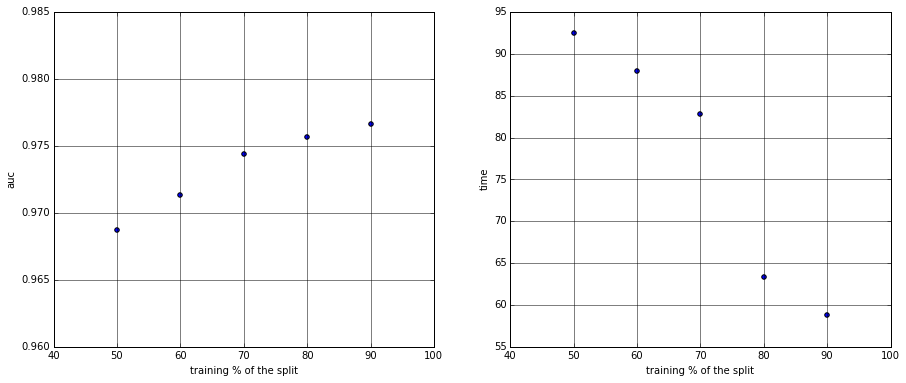

In [165]:
plt.figure(figsize=(15,6))
#plt.title(' space', fontsize=20)

plt.subplot(121)
plt.scatter(train_avg, avg)
plt.xlabel('training % of the split')
plt.ylabel('auc')
plt.grid(True,which="both",ls="-")


plt.subplot(122)
plt.scatter(train_time, time)
plt.xlabel('training % of the split')
plt.ylabel('time')
plt.grid(True,which="both",ls="-")


plt.show()

From the graph on the left we see that, as expected, the model trained with more data is more accurate in the prediction.

Looking at the training time we see that it decreases when the training part is bigger, this is because in our time measurements we include the training and the validation of the model. We think that in this case the calculation of the auc is quite expensive.

# Outlier removal

We decided to remove user outliers. Here we consider as an outlier all users that have more than 200000 playcounts and more than 5000 different artists listened. 
Users in the first group are those that listen many times few artists, while users in the second group are those that listen many different artists. We think that these users can affect considerably our recommendations, expecially those that have many playcounts.

In [196]:
UsersPC_clean = UsersPC_clean.withColumnRenamed("sum(playCount)", "playCount")
UsersPC_clean_filtered =UsersPC_clean.filter(UsersPC_clean.playCount < 200000)

users_outliers_filtered = (
    UsersAS_clean
    .filter(UsersAS_clean.curiosity < 5000)
    .join(UsersPC_clean, UsersAS_clean.userID == UsersPC_clean.userID, "left_outer")
    .drop(UsersPC_clean.userID)
    .select('userID')
)


allData_filtered_without_outliers = (
    userArtistName_filtered
    .join(users_outliers_filtered, users_outliers_filtered.userID == userArtistName_filtered.userID, "left_outer")
    .drop(users_outliers_filtered.userID)
)


+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1059637|        674411|
|2064012|        548411|
|2069337|        390816|
|2023977|        285978|
|1046559|        183972|
|1052461|        175822|
|1070932|        168977|
|1031009|        167032|
|2020513|        165642|
|2062243|        151504|
|2069889|        143091|
|1001440|        136265|
|2014936|        135235|
|2017397|        134032|
|1024631|        122316|
|1007308|        111128|
|2023742|        102030|
|1058890|         98477|
|1021940|         97296|
|1059245|         96058|
+-------+--------------+
only showing top 20 rows



In [198]:
allData_filtered = allData_filtered_without_outliers.rdd.map(lambda r: Rating(r[0],r[1],r[2])).repartition(48).cache()


trainData_filtered, cvData_filtered = allData_filtered.randomSplit([9,1])
trainData_filtered.cache()
cvData_filtered.cache()

allItemIDs = np.array(allData_filtered.map(lambda x: x[1]).distinct().collect())
print(allItemIDs[0:5])
bAllItemIDs = sc.broadcast(allItemIDs)

[ 6881280  2162688 10084224 10234800 10385376]


In [199]:
model = ALS.trainImplicit(ratings=allData_filtered,rank=10,iterations=5,lambda_=1.0,alpha=40.0)


In [200]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))
# construct set of recommendated artists
#this is a set of the recommended aritsts
recArtist= set(r[1] for r in recommendations)

In [201]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
#print(artistByID.take(5))

In [202]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda s: artistNames(s) == True).values().collect()

print(recList)

['Maroon 5', 'The Killers', 'Green Day', 'Gwen Stefani', 'blink-182']


We can see that the recommended artists change completely. Looking at the artists, we see that three of them are rock bands, while our user likes mostly rap/hip-hop artists, and a bit of rock. 